In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pe
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import auc

In [2]:
coupon_item = pd.read_csv('coupon_item_mapping.csv')
cust_demograph = pd.read_csv('customer_demographics.csv')
cust_transact  = pd.read_csv('customer_transaction_data.csv')
item_data = pd.read_csv('item_data.csv')

In [3]:
camp = pd.read_csv('campaign_data.csv')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Train and Test data info

In [5]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [6]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

<AxesSubplot:>

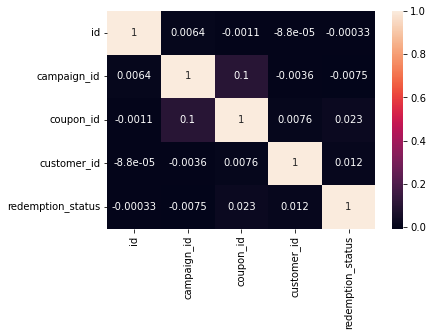

In [7]:
sns.heatmap(train.corr(),annot = True)

In [8]:
test.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [9]:
test.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id'], dtype='object')

In [10]:
for i in test.columns:
    print(i,"  " ,test[i].nunique())

id    50226
campaign_id    10
coupon_id    331
customer_id    1250


In [11]:
test[['campaign_id']].value_counts()

campaign_id
18             23464
20              5856
22              5796
17              3838
23              3295
25              3180
16              2256
19              1301
21              1040
24               200
dtype: int64

<AxesSubplot:>

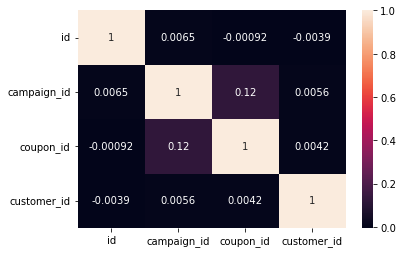

In [12]:
sns.heatmap(test.corr(),annot = True)

# coupon item understanding

In [13]:
coupon_item.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [14]:
coupon_item.shape

(92663, 2)

In [15]:
coupon_item.dtypes

coupon_id    int64
item_id      int64
dtype: object

In [16]:
coupon_item.isnull().sum()

coupon_id    0
item_id      0
dtype: int64

In [17]:
coupon_item['coupon_id'].nunique()

1116

In [18]:
coupon_item['item_id'].nunique()

36289

In [19]:
coupon_item.groupby('item_id')['coupon_id'].count()

item_id
1        2
4        3
7        2
10       4
12       2
        ..
74054    4
74056    2
74057    2
74058    2
74061    2
Name: coupon_id, Length: 36289, dtype: int64

In [20]:
pd.crosstab(coupon_item['item_id'],columns =['Coupons']).sort_values(by ='Coupons',ascending=False).head()

col_0,Coupons
item_id,
56523,11
34329,10
63983,10
21953,10
1071,10


Text(0, 0.5, 'coupon count')

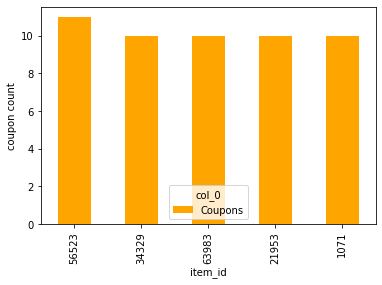

In [21]:
pd.crosstab(coupon_item['item_id'],columns =['Coupons']).sort_values(by ='Coupons',ascending=False).head().plot(kind ='bar',color ='orange')
plt.xlabel('item_id')
plt.ylabel('coupon count')

In [22]:
pd.crosstab(coupon_item['coupon_id'],columns =['items']).sort_values(by ='items',ascending=False).head()

col_0,items
coupon_id,
32,11814
23,11813
22,4947
31,4873
24,4394


<AxesSubplot:xlabel='coupon_id'>

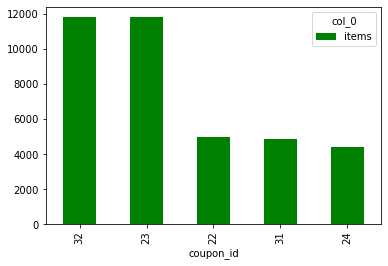

In [23]:
pd.crosstab(coupon_item['coupon_id'],columns =['items']).sort_values(by ='items',ascending=False).head().plot(kind ='bar',color ='green')

# campaign understanding

In [24]:
camp.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [25]:
camp.dtypes

# start_date and end_date should be in date format but are in strings they need to be type casted

campaign_id       int64
campaign_type    object
start_date       object
end_date         object
dtype: object

In [26]:
camp.start_date = pd.to_datetime(camp.start_date)
camp.end_date = pd.to_datetime(camp.end_date)

In [27]:
camp.dtypes

campaign_id               int64
campaign_type            object
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [28]:
camp.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,2013-10-21,2013-12-20
1,25,Y,2013-10-21,2013-11-22
2,20,Y,2013-07-09,2013-11-16
3,23,Y,2013-08-10,2013-11-15
4,21,Y,2013-09-16,2013-10-18


In [29]:
camp.isnull().sum()

campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64

In [30]:
camp.shape

(28, 4)

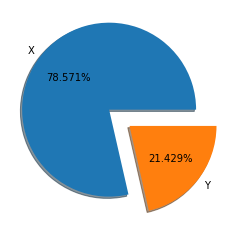

In [31]:
plt.pie(camp.campaign_type.value_counts(),labels = ['X','Y'],autopct = '%.3f%%',explode = [0.1,0.2],shadow=True)
plt.show()

# CUSTOMER TRANSACTION UNDERESTANDING

In [32]:
cust_transact = pd.read_csv('customer_transaction_data.csv')

In [33]:
cust_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [34]:
cust_transact.dtypes
# date is in object and needs to be converted to date

date                object
customer_id          int64
item_id              int64
quantity             int64
selling_price      float64
other_discount     float64
coupon_discount    float64
dtype: object

In [35]:
cust_transact.date = pd.to_datetime(cust_transact.date)

Datatypes after converting date column from object to date.

In [36]:
cust_transact.dtypes

date               datetime64[ns]
customer_id                 int64
item_id                     int64
quantity                    int64
selling_price             float64
other_discount            float64
coupon_discount           float64
dtype: object

In [37]:
# it would be proper to organise the data in some order based on the variables present
# date could be the best one as the records will be sorted according to the month of purchase and redemption

In [38]:
cust_transact = cust_transact.sort_values(by = 'date',ascending = True)

In [39]:
cust_transact.reset_index(drop = True,inplace=True)

In [40]:
cust_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62
2,2012-01-02,464,20717,2,28.50,-27.78,0.00
3,2012-01-02,464,21008,1,35.26,-17.81,0.00
4,2012-01-02,464,22243,2,118.97,-22.80,0.00


In [41]:
unique = []
for i in cust_transact.columns:
    print("The number of unique values in ",i)
    print(cust_transact[i].nunique())
    unique.append(cust_transact[i].nunique())

The number of unique values in  date
549
The number of unique values in  customer_id
1582
The number of unique values in  item_id
74063
The number of unique values in  quantity
9252
The number of unique values in  selling_price
4923
The number of unique values in  other_discount
1418
The number of unique values in  coupon_discount
232


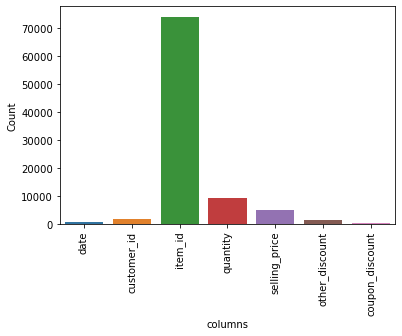

In [42]:
sns.barplot(x = cust_transact.columns,y = unique)
plt.xlabel("columns")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.show()

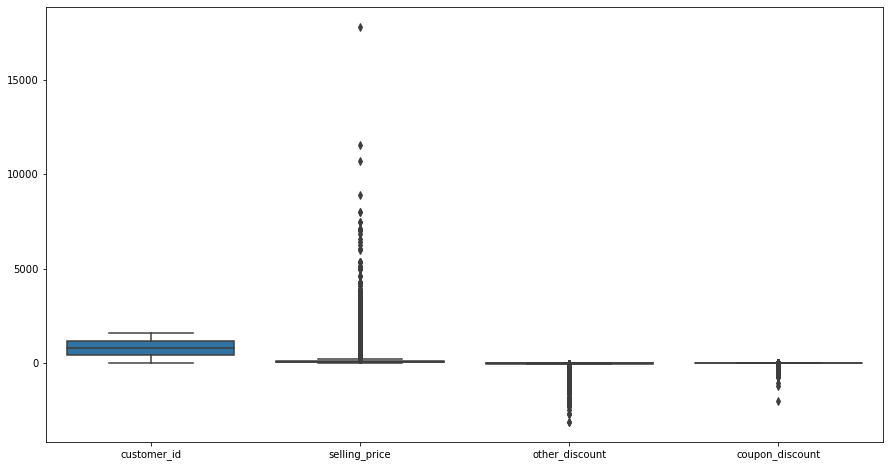

In [43]:
plt.figure(figsize=(15,8))
sns.boxplot(data = cust_transact.drop(['item_id','quantity'],axis=1))
plt.show()

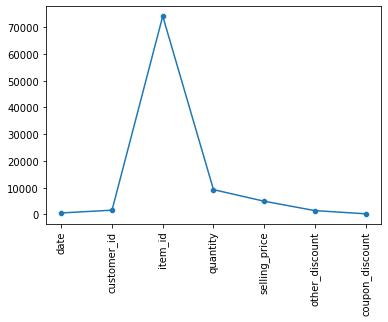

In [44]:
sns.scatterplot(x = cust_transact.columns,y = unique)
sns.lineplot(x = cust_transact.columns,y = unique)
plt.xticks(rotation =90)
plt.show()

# ITEM DATA UNDERSTANDING

In [45]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [46]:
cr =pd.crosstab(item_data['brand_type'],item_data['brand']).T

In [47]:
cr.sort_values(by=['Established'],ascending=False).head()

brand_type,Established,Local
brand,,
686,1142,0
1,1091,0
4700,923,0
1262,906,0
487,735,0


In [48]:
item_data['brand_type'].value_counts()

Established    62842
Local          11224
Name: brand_type, dtype: int64

In [49]:
item_data.isnull().sum()

item_id       0
brand         0
brand_type    0
category      0
dtype: int64

In [50]:
item_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [51]:
item_data.brand_type.value_counts()

Established    62842
Local          11224
Name: brand_type, dtype: int64

In [52]:
item_data.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

<AxesSubplot:xlabel='brand_type', ylabel='count'>

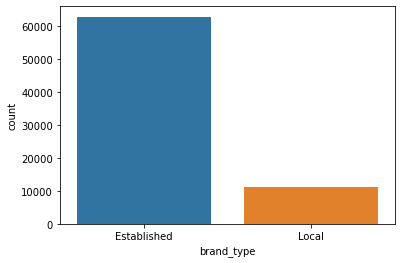

In [53]:
sns.countplot(item_data.brand_type)

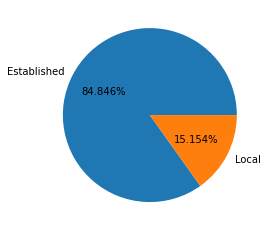

In [54]:
plt.pie(item_data.brand_type.value_counts(),labels = ['Established','Local'],autopct = '%.3f%%')
plt.show()

In [55]:
item_data.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

In [56]:
item_data.category.unique()

array(['Grocery', 'Miscellaneous', 'Bakery', 'Pharmaceutical',
       'Packaged Meat', 'Seafood', 'Natural Products',
       'Dairy, Juices & Snacks', 'Prepared Food', 'Skin & Hair Care',
       'Meat', 'Travel', 'Flowers & Plants', 'Fuel', 'Salads', 'Alcohol',
       'Garden', 'Restauarant', 'Vegetables (cut)'], dtype=object)

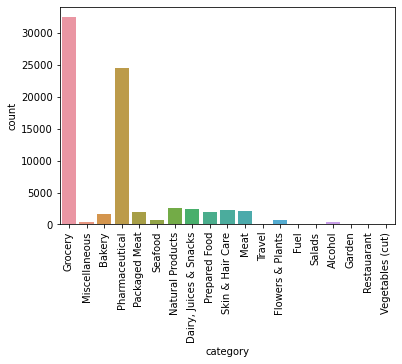

In [57]:
sns.countplot(item_data.category)
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:xlabel='category'>

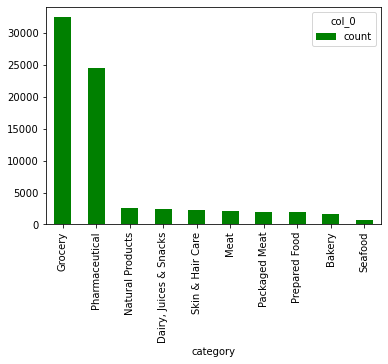

In [58]:
pd.crosstab(item_data.category,columns ='count').sort_values(by ='count',ascending=False).head(10).plot(kind ='bar',color ='green')

# customer Demographs understanding and cleaning

In [59]:
cust_demograph.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [60]:
cust_demograph.dtypes 

customer_id        int64
age_range         object
marital_status    object
rented             int64
family_size       object
no_of_children    object
income_bracket     int64
dtype: object

In [61]:
## The data set consists of following datatypes
## 3-Numerical Features (The Features income bracket and rented are pre encoded categorical features)
## 4-Categorical Features

In [62]:
cust_demograph.shape

(760, 7)

In [63]:
cust_demograph['customer_id'].nunique()

760

In [64]:
cust_demograph.duplicated().sum()

0

In [65]:
# there are no duplicate rows in the dataset

In [66]:
cust_demograph.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [67]:
cust_demograph.isnull().sum()/len(cust_demograph)*100

customer_id        0.000000
age_range          0.000000
marital_status    43.289474
rented             0.000000
family_size        0.000000
no_of_children    70.789474
income_bracket     0.000000
dtype: float64

In [68]:
## The dataset is consisting of null values in two features
## marital_status - 43.28%
## no_of_children - 70.78%

# Handling null values

In [69]:
df3 = cust_demograph.copy(deep=True) #(for logical imputation i will be using the df3)

In [70]:
df3.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [71]:
df3['age_range'].value_counts()

46-55    271
36-45    187
26-35    130
70+       68
56-70     59
18-25     45
Name: age_range, dtype: int64

In [72]:
### Below i have splitted the df3 data frame into 6 different dataframes 
### based on the age buckets for imputing the null values 

In [73]:
df_46_55 = df3[df3["age_range"] == "46-55"]
df_36_45 = df3[df3["age_range"] == "36-45"]
df_26_35 = df3[df3["age_range"] == "26-35"]
df_70above = df3[df3["age_range"] == "70+"]
df_56_70 = df3[df3["age_range"] == "56-70"]
df_18_25 = df3[df3["age_range"] == "18-25"]

In [74]:
### imputing the null values based on the above age buckets data

In [75]:
df_18_25['marital_status'].mode()

0    Single
Name: marital_status, dtype: object

In [76]:
df_18_25['marital_status'] = df_18_25['marital_status'].fillna('Single')

In [77]:
df_26_35['marital_status'].mode()

0    Married
Name: marital_status, dtype: object

In [78]:
df_26_35['marital_status'] = df_26_35['marital_status'].fillna(df_26_35['marital_status'].mode()[0])

In [79]:
df_36_45['marital_status'].mode()

0    Married
Name: marital_status, dtype: object

In [80]:
df_36_45['marital_status'] = df_36_45['marital_status'].fillna(df_36_45['marital_status'].mode()[0])

In [81]:
df_46_55['marital_status'].mode()

0    Married
Name: marital_status, dtype: object

In [82]:
df_46_55['marital_status'] = df_46_55['marital_status'].fillna(df_46_55['marital_status'].mode()[0])

In [83]:
df_56_70['marital_status'].mode()

0    Married
Name: marital_status, dtype: object

In [84]:
df_56_70['marital_status'] = df_56_70['marital_status'].fillna(df_56_70['marital_status'].mode()[0])

In [85]:
df_70above['marital_status'].mode()

0    Married
Name: marital_status, dtype: object

In [86]:
df_70above['marital_status'] = df_70above['marital_status'].fillna(df_70above['marital_status'].mode()[0])

In [87]:
print(df_46_55['marital_status'].isnull().sum())
print(df_36_45['marital_status'].isnull().sum())
print(df_26_35['marital_status'].isnull().sum())
print(df_70above['marital_status'].isnull().sum())
print(df_56_70['marital_status'].isnull().sum())
print(df_18_25['marital_status'].isnull().sum())

0
0
0
0
0
0


In [88]:
### Combining the datasets

In [89]:
df4 = pd.concat([df_46_55,df_36_45,df_26_35,df_70above,df_56_70,df_18_25])

In [90]:
df4.shape

(760, 7)

In [91]:
df4['marital_status'].value_counts()

Married    620
Single     140
Name: marital_status, dtype: int64

In [92]:
df4.isnull().sum()

customer_id         0
age_range           0
marital_status      0
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [93]:
### Will be imputing the null values in the based on the family size

In [94]:
df4['family_size'].value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [95]:
df_fam_2 = df4[df4["family_size"] == "2"]
df_fam_1 = df4[df4["family_size"] == "1"]
df_fam_3 = df4[df4["family_size"] == "3"]
df_fam_5abv = df4[df4["family_size"] == "5+"]
df_fam4 = df4[df4["family_size"] == "4"]

In [96]:
print(df_fam_2['no_of_children'].isnull().sum())
print(df_fam_1['no_of_children'].isnull().sum())
print(df_fam_3['no_of_children'].isnull().sum())
print(df_fam_5abv['no_of_children'].isnull().sum())
print(df_fam4['no_of_children'].isnull().sum())

290
248
0
0
0


In [97]:
### Here the null values are only present in the families with familiy size 2 and family size 1

In [98]:
df_fam_2.shape

(303, 7)

In [99]:
df_fam_2['no_of_children'].isnull().sum()

290

In [100]:
df_fam_2['no_of_children'].value_counts()

1    13
Name: no_of_children, dtype: int64

In [101]:
### Here we can clrealy see that only 13 members from the bucket family size 2
### has given the info regarding the children - the no:of:children for them is 1.
### 290 members has not given any information - either we can assume that they are not having children
### or we can go with mode value of the which is 13.

In [102]:
df_fam_2['no_of_children'] = df_fam_2['no_of_children'].fillna('0')

In [103]:
df_fam_2['no_of_children'].value_counts()

0    290
1     13
Name: no_of_children, dtype: int64

In [104]:
df_fam_1.shape

(248, 7)

In [105]:
df_fam_1['no_of_children'].isnull().sum()

248

In [106]:
df_fam_1['no_of_children'].value_counts()

Series([], Name: no_of_children, dtype: int64)

In [107]:
### Here we can clearly see that the all 248 values belonging to the family size 1 
### are null values based on this fact i am assuming that they are not having children 
### and i will be populating the null values with zero

In [108]:
df_fam_1['no_of_children'] = df_fam_1['no_of_children'].fillna('0')

In [109]:
df_fam_1['no_of_children'].value_counts()

0    248
Name: no_of_children, dtype: int64

In [110]:
print(df_fam_2['no_of_children'].isnull().sum())
print(df_fam_1['no_of_children'].isnull().sum())
print(df_fam_3['no_of_children'].isnull().sum())
print(df_fam_5abv['no_of_children'].isnull().sum())
print(df_fam4['no_of_children'].isnull().sum())

0
0
0
0
0


In [111]:
### Combining the datasets

In [112]:
cust_demograph = pd.concat([df_fam_2,df_fam_1,df_fam_3,df_fam_5abv,df_fam4])

In [113]:
cust_demograph.shape

(760, 7)

In [114]:
cust_demograph['no_of_children'].value_counts()

0     538
1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [115]:
for i in cust_demograph.index:
    if cust_demograph.no_of_children[i] == '3+':
        cust_demograph.no_of_children[i] = '3'

In [116]:
for i in cust_demograph.index:
    if cust_demograph.family_size[i] == '5+':
        cust_demograph.family_size[i] = '5'

In [117]:
cust_demograph.family_size.value_counts()

2    303
1    248
3    104
5     57
4     48
Name: family_size, dtype: int64

In [118]:
cust_demograph.no_of_children.value_counts()

0    538
1    107
3     60
2     55
Name: no_of_children, dtype: int64

# Feature Engineering ############

In [119]:
# the variables available are self explainatory hence we will just do encoding on categorical variables post data sets merging
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [120]:
# the columns are one to one and one to many mapped w.r.t the data hence there is no need for creation of additional features
coupon_item.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [121]:
cust_demograph.head()
# the dataset look prettymuch self explainatory and there are very less possibilities for creating a new feature that can add up to the current information

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
1,6,46-55,Married,0,2,0,5
6,12,46-55,Married,0,2,0,7
9,15,46-55,Married,0,2,0,6
14,28,46-55,Married,0,2,0,1
20,38,46-55,Single,0,2,0,5


In [122]:
camp.head(7)

,campaign_id,campaign_type,start_date,end_date
0,24,Y,2013-10-21,2013-12-20
1,25,Y,2013-10-21,2013-11-22
2,20,Y,2013-07-09,2013-11-16
3,23,Y,2013-08-10,2013-11-15
4,21,Y,2013-09-16,2013-10-18
5,22,X,2013-09-16,2013-10-18
6,18,X,2013-10-08,2013-04-10


In [123]:
# here the possibilities are encoding the campaign_type which will be done after merge
# for creating new features to give additional details we can get the duration of the campaign
# duration of the campaign = end_date - start date in terms of days.

# reverifying the date columns to be in required datatype and proceeding with feature creation

In [124]:
camp.dtypes
# data type condition satisfied

campaign_id               int64
campaign_type            object
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [125]:
camp.end_date - camp.start_date

0      60 days
1      32 days
2     130 days
3      97 days
4      32 days
5      32 days
6    -181 days
7      32 days
8      32 days
9      32 days
10    -12 days
11     75 days
12     32 days
13     62 days
14     31 days
15     77 days
16    182 days
17    -25 days
18     56 days
19   -289 days
20     32 days
21     37 days
22     32 days
23    133 days
24    112 days
25     61 days
26     63 days
27    -78 days
dtype: timedelta64[ns]

In [126]:
date_diff_error = camp[camp.end_date < camp.start_date]

In [127]:
date_diff_error

,campaign_id,campaign_type,start_date,end_date
6,18,X,2013-10-08,2013-04-10
10,13,X,2013-05-19,2013-05-07
17,6,Y,2013-01-28,2013-01-03
19,5,Y,2013-12-01,2013-02-15
27,26,X,2012-12-08,2012-09-21


In [128]:
new_end = []
new_start = []
for i in date_diff_error.index:
    new_end.append(date_diff_error['start_date'][i])
    new_start.append(date_diff_error['end_date'][i])

In [129]:
idx =camp[camp.end_date < camp.start_date].index

In [130]:
camp['start_date'].loc[idx] = new_start

In [131]:
camp['end_date'].loc[idx] = new_end

In [132]:
camp[camp.end_date < camp.start_date]

,campaign_id,campaign_type,start_date,end_date


# verifying for proper date difference values after making required changes

In [133]:
camp['diff_d']=round((camp['end_date']-camp['start_date'])/np.timedelta64(3,'D'))

In [134]:
camp.dtypes

campaign_id               int64
campaign_type            object
start_date       datetime64[ns]
end_date         datetime64[ns]
diff_d                  float64
dtype: object

In [135]:
camp['diff_d'] = camp['diff_d'].astype('int64')

In [136]:
camp.dtypes

campaign_id               int64
campaign_type            object
start_date       datetime64[ns]
end_date         datetime64[ns]
diff_d                    int64
dtype: object

In [137]:
camp.head()

,campaign_id,campaign_type,start_date,end_date,diff_d
0,24,Y,2013-10-21,2013-12-20,20
1,25,Y,2013-10-21,2013-11-22,11
2,20,Y,2013-07-09,2013-11-16,43
3,23,Y,2013-08-10,2013-11-15,32
4,21,Y,2013-09-16,2013-10-18,11


# Customer Transactions

In [138]:
cust_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62
2,2012-01-02,464,20717,2,28.50,-27.78,0.00
3,2012-01-02,464,21008,1,35.26,-17.81,0.00
4,2012-01-02,464,22243,2,118.97,-22.80,0.00


In [139]:
# date column can be split into the day,month,year in order to seggregate information based on month/day/year respectively
# the other pricing metrics like marked price, unit price of an item can be created
# further refining of data may include seggregating multiple data of same customers on a same day
# into one single record considering total or mean of purchases by that customer on the same day
# we can also check if the coupon is udes i.e. redeemed based on the value in coupon_discount column

In [140]:
def date_sep(df):  
    day = []
    month = []
    year = []
    for i in df['date']:
        day.append(i.day)
        month.append(i.month)
        year.append(i.year)
    df['day'] =day
    df['month'] = month
    df['year'] = year

In [141]:
date_sep(cust_transact)

In [142]:
cust_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,month,year
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,2,1,2012
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62,2,1,2012
2,2012-01-02,464,20717,2,28.50,-27.78,0.00,2,1,2012
3,2012-01-02,464,21008,1,35.26,-17.81,0.00,2,1,2012
4,2012-01-02,464,22243,2,118.97,-22.80,0.00,2,1,2012


In [143]:
# the selling price,discount and coupon discount mentioned are for the entire transaction
# not 1 quantity specific hence we can create columns giving information of cost/unit

In [144]:
cust_transact.Unit_price =  round(cust_transact.selling_price/cust_transact.quantity,2)
cust_transact.Unit_price.head()

0    35.26
1    92.26
2    14.25
3    35.26
4    59.48
dtype: float64

In [145]:
# coupon discount per item
cust_transact['unit_discount'] = round(cust_transact['other_discount']/cust_transact['quantity'],2)
cust_transact['unit_discount'].head()

0   -10.69
1   -21.37
2   -13.89
3   -17.81
4   -11.40
Name: unit_discount, dtype: float64

In [146]:
# other discount per item
cust_transact['unit_other_disc'] = cust_transact['other_discount']/cust_transact['quantity']

In [147]:
cust_transact['unit_other_disc'].head()

0   -10.69
1   -21.37
2   -13.89
3   -17.81
4   -11.40
Name: unit_other_disc, dtype: float64

In [148]:
coupon_usage = []
for i in cust_transact['coupon_discount']:
    if i == 0.0:
        coupon_usage.append(0)
    else:
        coupon_usage.append(1)

In [149]:
pd.DataFrame(coupon_usage,columns =['usage']).value_counts()

usage
0        1303280
1          21286
dtype: int64

In [150]:
cust_transact['Coupon_utilized'] = coupon_usage

In [151]:
len(cust_transact[cust_transact.coupon_discount == 0.0])

1303280

In [152]:
len(cust_transact[cust_transact.coupon_discount != 0.0])

21286

In [153]:
cust_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,month,year,unit_discount,unit_other_disc,Coupon_utilized
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,2,1,2012,-10.69,-10.69,0
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62,2,1,2012,-21.37,-21.37,1
2,2012-01-02,464,20717,2,28.50,-27.78,0.00,2,1,2012,-13.89,-13.89,0
3,2012-01-02,464,21008,1,35.26,-17.81,0.00,2,1,2012,-17.81,-17.81,0
4,2012-01-02,464,22243,2,118.97,-22.80,0.00,2,1,2012,-11.40,-11.40,0


In [154]:
id =[]
for i in cust_transact['customer_id']:
    if i in cust_demograph['customer_id']:
        if i not in id:
            id.append(i)

In [155]:
len(id)

759

In [156]:
cust_transact.customer_id.value_counts()

1555    4522
711     4173
464     4134
1475    3945
1011    3862
        ... 
1150      87
1180      83
406       83
907       80
1326      79
Name: customer_id, Length: 1582, dtype: int64

In [157]:
cust_transact.customer_id.nunique()

1582

In [158]:
id =[]
for i in cust_transact['customer_id']:
    if i not in cust_demograph['customer_id']:
        if i not in id:
              id.append(i)

In [160]:
len(id)

823

# Merging the datasets 

# merging coupon_item and item_data based on item_id

In [161]:
coupon_item.shape,item_data.shape

((92663, 2), (74066, 4))

In [162]:
coupon_item_merge = pd.merge(left =coupon_item,right =item_data,on ='item_id',how ='left')

In [163]:
coupon_item_merge.isnull().sum()

coupon_id     0
item_id       0
brand         0
brand_type    0
category      0
dtype: int64

In [164]:
coupon_item_merge.shape

(92663, 5)

# customer Transaction table merging with coupon_item_merge

In [165]:
# the normal merge results in a large number of null values and huge increase in data i.e. from 130000+ to 2100000+ records in right join
# to 2600000 in left join as a result the customer transactio table has to be seggregated in such a way that the item counts are in sync with the
# number of items in item_data table 
# so an aggregate function has to be used while grouping 
# or pivot table can also be used

In [166]:
cust_transact.columns

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'day', 'month', 'year',
       'unit_discount', 'unit_other_disc', 'Coupon_utilized'],
      dtype='object')

In [167]:
cust_transact.groupby(['item_id']).agg({'customer_id':lambda x :len(set(x)),'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,})

,customer_id,quantity,selling_price,other_discount,coupon_discount
item_id,,,,,
1,2,2,248.62,0.0,0.0
2,1,1,35.26,0.0,0.0
3,1,1,56.64,0.0,0.0
4,1,1,54.85,0.0,0.0
5,1,1,81.57,0.0,0.0
...,...,...,...,...,...
74062,1,1,447.03,0.0,0.0
74063,1,1,414.97,0.0,0.0
74064,1,1,414.97,0.0,0.0


In [168]:
sum_of_transactions = pd.DataFrame(cust_transact.groupby(['item_id']).agg({'customer_id':lambda x:len(set(x)),'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,}),columns = ['customer_id','quantity','selling_price', 'other_discount','coupon_discount'])

In [169]:
sum_of_transactions.reset_index(inplace=True)
sum_of_transactions = sum_of_transactions.rename(columns = {'customer_id':'Customer_count'})
sum_of_transactions.columns

Index(['item_id', 'Customer_count', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount'],
      dtype='object')

In [170]:
mean_transactions = pd.DataFrame(cust_transact.groupby(['item_id']).agg({'customer_id':len,'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'Coupon_utilized': np.sum}))

In [171]:
mean_transactions.reset_index(inplace = True)
mean_transactions = mean_transactions.rename(columns ={'customer_id':'cust_transactions','quantity':'quantity_mean','selling_price':'sellingPrice_mean','other_discount':'other_discount_mean','coupon_discount':'coupon_discount_mean'})

In [172]:
# transactions1 = pd.merge(transactions1, transactions2, on='item_id',how='left' )
combined_transactions = pd.merge(right =mean_transactions,left =sum_of_transactions,on ='item_id',how ='left')

In [173]:
combined_transactions

,item_id,Customer_count,quantity,selling_price,other_discount,coupon_discount,cust_transactions,quantity_mean,sellingPrice_mean,other_discount_mean,coupon_discount_mean,Coupon_utilized
0,1,2,2,248.62,0.0,0.0,2,1.0,124.31,0.0,0.0,0
1,2,1,1,35.26,0.0,0.0,1,1.0,35.26,0.0,0.0,0
2,3,1,1,56.64,0.0,0.0,1,1.0,56.64,0.0,0.0,0
3,4,1,1,54.85,0.0,0.0,1,1.0,54.85,0.0,0.0,0
4,5,1,1,81.57,0.0,0.0,1,1.0,81.57,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
74058,74062,1,1,447.03,0.0,0.0,1,1.0,447.03,0.0,0.0,0
74059,74063,1,1,414.97,0.0,0.0,1,1.0,414.97,0.0,0.0,0
74060,74064,1,1,414.97,0.0,0.0,1,1.0,414.97,0.0,0.0,0
74061,74065,1,1,127.88,0.0,0.0,1,1.0,127.88,0.0,0.0,0


In [174]:
# we seperated data as sum and mean values hence its better to add the discount for the same respectively i.e mean discount and sum_discount

In [175]:
combined_transactions['total_discount_sum'] = combined_transactions['other_discount']+ combined_transactions['coupon_discount']

In [176]:
combined_transactions['total_discount_mean'] = combined_transactions['other_discount_mean']+ combined_transactions['coupon_discount_mean']

# combining the combined_transactions with coupon_item_merge on item_id 

In [177]:
coupon_item_merge.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery


In [178]:
item_coupon_transaction = pd.merge(left =coupon_item_merge,right =combined_transactions,on ='item_id',how ='left')

In [179]:
item_coupon_transaction.head()

,coupon_id,item_id,brand,brand_type,category,Customer_count,quantity,selling_price,other_discount,coupon_discount,cust_transactions,quantity_mean,sellingPrice_mean,other_discount_mean,coupon_discount_mean,Coupon_utilized,total_discount_sum,total_discount_mean
0,105,37,56,Local,Grocery,2.0,16.0,791.84,-122.90,0.0,7.0,2.285714,113.120000,-17.557143,0.0,0.0,-122.90,-17.557143
1,107,75,56,Local,Grocery,4.0,45.0,1576.98,-170.26,0.0,33.0,1.363636,47.787273,-5.159394,0.0,0.0,-170.26,-5.159394
2,494,76,209,Established,Grocery,1.0,1.0,89.05,-17.45,0.0,1.0,1.000000,89.050000,-17.450000,0.0,0.0,-17.45,-17.450000
3,522,77,278,Established,Grocery,2.0,2.0,140.70,-33.84,0.0,2.0,1.000000,70.350000,-16.920000,0.0,0.0,-33.84,-16.920000
4,518,77,278,Established,Grocery,2.0,2.0,140.70,-33.84,0.0,2.0,1.000000,70.350000,-16.920000,0.0,0.0,-33.84,-16.920000


In [180]:
# the combined table needs to be combined with train as a result coupon id is the source of connection.

In [181]:
train.shape

(78369, 5)

In [182]:
item_coupon_transaction = item_coupon_transaction.rename(columns ={'customer_count':'customer_transactions'})

In [183]:
item_coupon_transaction.columns

Index(['coupon_id', 'item_id', 'brand', 'brand_type', 'category',
       'Customer_count', 'quantity', 'selling_price', 'other_discount',
       'coupon_discount', 'cust_transactions', 'quantity_mean',
       'sellingPrice_mean', 'other_discount_mean', 'coupon_discount_mean',
       'Coupon_utilized', 'total_discount_sum', 'total_discount_mean'],
      dtype='object')

# aggregating coupon transactions based on coupon id

In [184]:
coupon_agg = pd.DataFrame(item_coupon_transaction.groupby(['coupon_id']).agg
             ({'item_id':lambda x: len(set(x)),'brand':lambda x: mode(x)[0][0],'brand_type':lambda x: mode(x)[0][0],
                'category':lambda x: mode(x)[0][0],'Customer_count': np.mean,'quantity':np.sum,'selling_price':np.sum,'other_discount':np.sum,
                'coupon_discount':np.sum,
               'cust_transactions':len,
                'quantity_mean':np.mean,
                'sellingPrice_mean':np.mean,
               'other_discount_mean':np.mean,
               'coupon_discount_mean':np.mean,
               'Coupon_utilized': np.sum,
                'total_discount_mean': np.mean,
                'total_discount_sum': np.sum
              }))

In [185]:
coupon_agg.reset_index(inplace=True)

In [186]:
coupon_agg.head()
# here item_id represents the items for thay particular coupon hence changin the colummn name to item count

,coupon_id,item_id,brand,brand_type,category,Customer_count,quantity,selling_price,other_discount,coupon_discount,cust_transactions,quantity_mean,sellingPrice_mean,other_discount_mean,coupon_discount_mean,Coupon_utilized,total_discount_mean,total_discount_sum
0,1,39,1475,Established,Natural Products,14.794872,1034.0,88272.89,-24468.37,-1526.31,39,1.221644,100.195701,-25.273218,-1.321524,35.0,-26.594742,-25994.68
1,2,2,2084,Established,Grocery,15.000000,103.0,9883.21,-1478.75,0.00,2,1.137500,114.354437,-23.314062,0.000000,0.0,-23.314062,-1478.75
2,3,17,278,Established,Grocery,8.588235,248.0,27498.59,-4952.62,-578.81,17,1.121525,129.981640,-17.543797,-2.747358,15.0,-20.291155,-5531.43
3,4,24,544,Established,Grocery,22.333333,702.0,121581.84,-26804.05,-881.59,24,1.020872,178.722897,-37.411408,-1.485152,44.0,-38.896560,-27685.64
4,5,7,5357,Established,Pharmaceutical,6.000000,44.0,15407.69,-1228.88,0.00,7,1.000000,376.704214,-27.265786,0.000000,0.0,-27.265786,-1228.88


In [187]:
coupon_agg = coupon_agg.rename(columns ={'item_id':'item_count'})

In [188]:
coupon_agg.columns

Index(['coupon_id', 'item_count', 'brand', 'brand_type', 'category',
       'Customer_count', 'quantity', 'selling_price', 'other_discount',
       'coupon_discount', 'cust_transactions', 'quantity_mean',
       'sellingPrice_mean', 'other_discount_mean', 'coupon_discount_mean',
       'Coupon_utilized', 'total_discount_mean', 'total_discount_sum'],
      dtype='object')

In [189]:
# mergoing the coupon_agg with train data

In [190]:
train = pd.merge(left=train,right = coupon_agg,how ='left',on='coupon_id')

In [191]:
# aggregating customer transaction on customer id inorder to merge with train data

In [192]:
cust_transact.columns

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'day', 'month', 'year',
       'unit_discount', 'unit_other_disc', 'Coupon_utilized'],
      dtype='object')

In [193]:
# columns considered for aggregate - item_id,quantity,selling_price,other_discount,coupon_discount,day,month,year,Coupon_utilized
coupon_trans_mean = pd.DataFrame(cust_transact.groupby(['customer_id']).agg( {'item_id':lambda x: len(set(x)),
                        'selling_price':np.sum,
                        'quantity':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,
                        'day':lambda x: x.mode()[0],
                        'month':lambda x: x.mode()[0],
                        'year':lambda x: x.mode()[0],                                                  
                        'Coupon_utilized': np.sum}))

In [194]:
coupon_trans_mean.reset_index(inplace=True)

In [195]:
coupon_trans_mean.columns

Index(['customer_id', 'item_id', 'selling_price', 'quantity', 'other_discount',
       'coupon_discount', 'day', 'month', 'year', 'Coupon_utilized'],
      dtype='object')

In [196]:
coupon_trans_mean =coupon_trans_mean.rename(columns = {'selling_price':'selling_price_mean','quantity':'quantity_mean','other_discount':'other_discount_mean',
                                  'coupon_discount':'coupon_discount_mean','item_id':'item_count'})

In [197]:
coupon_trans_mean.columns

Index(['customer_id', 'item_count', 'selling_price_mean', 'quantity_mean',
       'other_discount_mean', 'coupon_discount_mean', 'day', 'month', 'year',
       'Coupon_utilized'],
      dtype='object')

In [198]:
coupon_trans_mean.rename(columns ={'item_id':'item_count'})

,customer_id,item_count,selling_price_mean,quantity_mean,other_discount_mean,coupon_discount_mean,day,month,year,Coupon_utilized
0,1,463,98513.93,1227,-17030.40,-2116.83,3,5,2012,78
1,2,352,43100.03,474,-7051.95,-249.34,13,6,2012,4
2,3,406,73050.27,8163,-16013.53,-2179.54,16,7,2012,53
3,4,125,33973.22,280,-2927.19,-89.05,14,5,2012,1
4,5,490,103615.10,93353,-10817.07,-90.83,11,5,2012,2
...,...,...,...,...,...,...,...,...,...,...
1577,1578,481,82019.46,107107,-14583.83,-767.62,6,7,2012,29
1578,1579,639,146358.89,1756,-26649.97,-338.39,4,4,2012,6
1579,1580,422,59426.10,20467,-6716.86,0.00,16,4,2013,0
1580,1581,390,57532.24,142571,-7457.38,0.00,23,3,2013,0


# aggregating based on sum of variables

In [199]:
coupon_trans_sum = cust_transact.groupby(['customer_id']).agg( {'item_id':len,
                        'selling_price':np.sum,
                        'quantity':np.sum,                       
                        'other_discount':np.sum,
                        'coupon_discount':np.sum})

In [200]:
coupon_trans_sum.reset_index(inplace=True)

In [201]:
coupon_trans_sum.columns

Index(['customer_id', 'item_id', 'selling_price', 'quantity', 'other_discount',
       'coupon_discount'],
      dtype='object')

# combined coupon transactions aggregated based on customer id

In [202]:
coupon_transactions = pd.merge(coupon_trans_mean, coupon_trans_sum, on='customer_id', how='left')

In [203]:
coupon_transactions.head()

,customer_id,item_count,selling_price_mean,quantity_mean,other_discount_mean,coupon_discount_mean,day,month,year,Coupon_utilized,item_id,selling_price,quantity,other_discount,coupon_discount
0,1,463,98513.93,1227,-17030.40,-2116.83,3,5,2012,78,1048,98513.93,1227,-17030.40,-2116.83
1,2,352,43100.03,474,-7051.95,-249.34,13,6,2012,4,419,43100.03,474,-7051.95,-249.34
2,3,406,73050.27,8163,-16013.53,-2179.54,16,7,2012,53,705,73050.27,8163,-16013.53,-2179.54
3,4,125,33973.22,280,-2927.19,-89.05,14,5,2012,1,220,33973.22,280,-2927.19,-89.05
4,5,490,103615.10,93353,-10817.07,-90.83,11,5,2012,2,792,103615.10,93353,-10817.07,-90.83


# merging tain and campaign on campaign_id

In [204]:
train = pd.merge(train,camp,on='campaign_id',how='left')

In [205]:
train = pd.merge(train,cust_demograph,on='customer_id',how='left')

In [206]:
train = pd.merge(train,coupon_transactions,on='customer_id',how='left')

In [207]:
train.shape

(78369, 46)

In [208]:
# checking train dataset size

In [209]:
train.isnull().sum()

id                            0
campaign_id                   0
coupon_id                     0
customer_id                   0
redemption_status             0
item_count_x                  0
brand                         0
brand_type                    0
category                      0
Customer_count                0
quantity_x                    0
selling_price_x               0
other_discount_x              0
coupon_discount_x             0
cust_transactions             0
quantity_mean_x               0
sellingPrice_mean             0
other_discount_mean_x         0
coupon_discount_mean_x        0
Coupon_utilized_x             0
total_discount_mean           0
total_discount_sum            0
campaign_type                 0
start_date                    0
end_date                      0
diff_d                        0
age_range                 34708
marital_status            34708
rented                    34708
family_size               34708
no_of_children            34708
income_b

In [210]:
train

,id,campaign_id,coupon_id,customer_id,redemption_status,item_count_x,brand,brand_type,category,Customer_count,...,coupon_discount_mean_y,day,month,year,Coupon_utilized_y,item_id,selling_price_y,quantity_y,other_discount_y,coupon_discount_y
0,1,13,27,1053,0,125,1105,Established,Grocery,19.224000,...,-89.05,11,5,2013,1,310,57120.75,105551,-10282.37,-89.05
1,2,13,116,48,0,3,56,Local,Grocery,20.333333,...,-1237.79,4,6,2012,12,385,90185.10,12143,-10664.18,-1237.79
2,6,9,635,205,0,67,560,Established,Pharmaceutical,1.761194,...,-2145.72,27,3,2012,85,970,117461.66,1351,-17261.79,-2145.72
3,7,13,644,1050,0,4,611,Established,Grocery,3.500000,...,-178.10,9,8,2012,2,237,23291.42,306,-3947.37,-178.10
4,9,8,1017,1489,0,32,1558,Established,Grocery,27.312500,...,-265.01,2,5,2012,10,562,67797.49,139063,-11534.90,-265.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,4,56,Local,Grocery,40.750000,...,0.00,6,5,2012,0,462,53058.23,492,-4186.34,0.00
78365,128589,30,547,937,0,7,2188,Established,Grocery,35.571429,...,-89.05,29,6,2012,1,257,22570.47,310,-4031.81,-89.05
78366,128590,8,754,1004,0,83,864,Established,Grocery,14.421687,...,-260.03,12,5,2013,6,1815,195328.75,168668,-26712.95,-260.03
78367,128592,13,134,71,0,7,11,Local,Grocery,44.571429,...,-1325.04,30,11,2012,50,938,81141.98,17945,-21222.86,-1325.04


In [211]:
# getting the mode values od the corresponding columns
for i in cust_demograph.columns[1:]:
    print(cust_demograph[i].mode())

0    46-55
Name: age_range, dtype: object
0    Married
Name: marital_status, dtype: object
0    0
Name: rented, dtype: int64
0    2
Name: family_size, dtype: object
0    0
Name: no_of_children, dtype: object
0    5
Name: income_bracket, dtype: int64


# missing values in train after merge  
age_range                 34708
marital_status            34708
rented                    34708
family_size               34708
no_of_children            34708
income_bracket            34708

In [212]:
train['age_range'] = train['age_range'].fillna('46-55')
train['marital_status'] = train['marital_status'].fillna('Married')
train['rented'] = train['rented'].fillna(0)
train['family_size'] = train['family_size'].fillna('2')
train['no_of_children'] = train['no_of_children'].fillna('0')
train['income_bracket'] = train['income_bracket'].fillna(5)

In [213]:
train.isnull().sum()

id                        0
campaign_id               0
coupon_id                 0
customer_id               0
redemption_status         0
item_count_x              0
brand                     0
brand_type                0
category                  0
Customer_count            0
quantity_x                0
selling_price_x           0
other_discount_x          0
coupon_discount_x         0
cust_transactions         0
quantity_mean_x           0
sellingPrice_mean         0
other_discount_mean_x     0
coupon_discount_mean_x    0
Coupon_utilized_x         0
total_discount_mean       0
total_discount_sum        0
campaign_type             0
start_date                0
end_date                  0
diff_d                    0
age_range                 0
marital_status            0
rented                    0
family_size               0
no_of_children            0
income_bracket            0
item_count_y              0
selling_price_mean        0
quantity_mean_y           0
other_discount_mean_

### PLOTS FOR REPORTING

<AxesSubplot:xlabel='redemption_status', ylabel='count'>

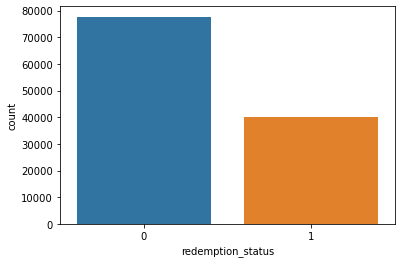

In [288]:
sns.countplot(prop_smote['redemption_status'])

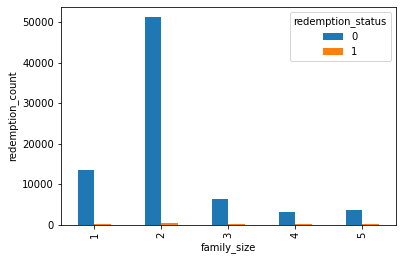

In [289]:
pd.crosstab(train['family_size'],train['redemption_status']).plot(kind='bar')
plt.ylabel("redemption_count")
plt.show()

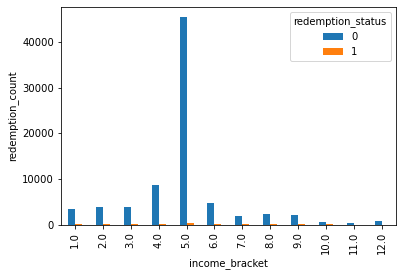

In [290]:
pd.crosstab(train['income_bracket'],train['redemption_status']).plot(kind='bar')
plt.ylabel("redemption_count")
plt.show()

<AxesSubplot:xlabel='category'>

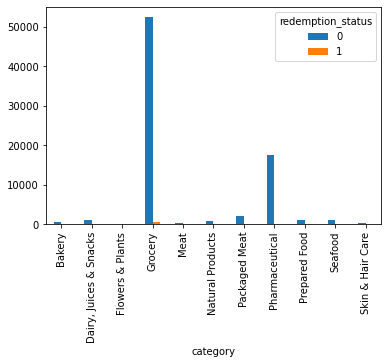

In [291]:
pd.crosstab(train['category'],train['redemption_status']).plot(kind='bar')

In [292]:
train.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'item_count_x', 'brand', 'brand_type', 'category', 'Customer_count',
       'quantity_x', 'selling_price_x', 'other_discount_x',
       'coupon_discount_x', 'cust_transactions', 'quantity_mean_x',
       'sellingPrice_mean', 'other_discount_mean_x', 'coupon_discount_mean_x',
       'Coupon_utilized_x', 'total_discount_mean', 'total_discount_sum',
       'campaign_type', 'start_date', 'end_date', 'diff_d', 'age_range',
       'marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket', 'item_count_y', 'selling_price_mean',
       'quantity_mean_y', 'other_discount_mean_y', 'coupon_discount_mean_y',
       'day', 'month', 'year', 'Coupon_utilized_y', 'item_id',
       'selling_price_y', 'quantity_y', 'other_discount_y',
       'coupon_discount_y'],
      dtype='object')

<AxesSubplot:xlabel='age_range', ylabel='count'>

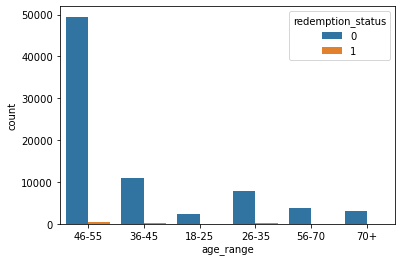

In [293]:
sns.countplot(train['age_range'],hue=train['redemption_status'])

<AxesSubplot:xlabel='no_of_children', ylabel='count'>

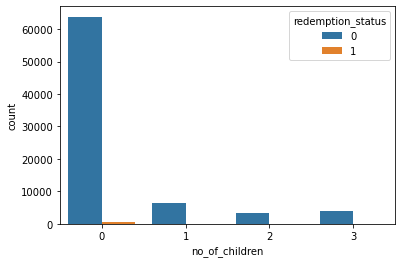

In [294]:
sns.countplot(train['no_of_children'],hue = train['redemption_status'])

Text(0.5, 1.0, 'customer transactions')

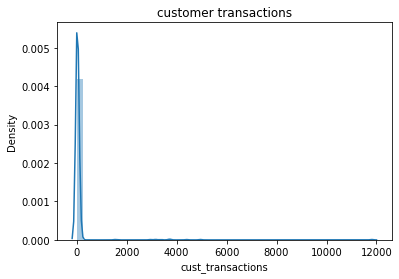

In [295]:
sns.distplot(train['cust_transactions'])
plt.title('customer transactions')

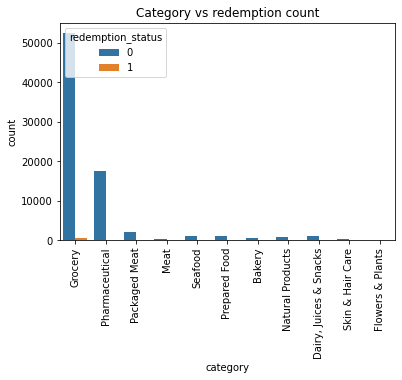

In [296]:
sns.countplot(train['category'],hue = train['redemption_status'])
plt.title('Category vs redemption count')
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:>

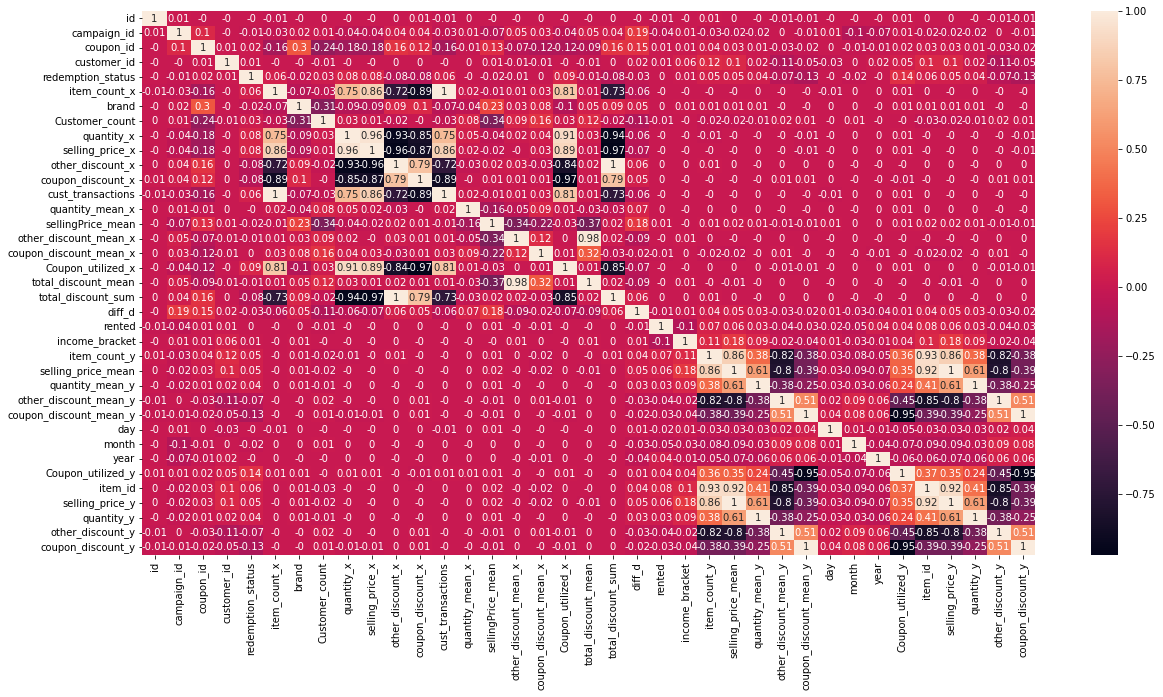

In [214]:
plt.figure(figsize=(20,10))
sns.heatmap(round(train.corr(),2),annot = True)

In [215]:
#    sns.pairplot(train)

In [216]:
train.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'item_count_x', 'brand', 'brand_type', 'category', 'Customer_count',
       'quantity_x', 'selling_price_x', 'other_discount_x',
       'coupon_discount_x', 'cust_transactions', 'quantity_mean_x',
       'sellingPrice_mean', 'other_discount_mean_x', 'coupon_discount_mean_x',
       'Coupon_utilized_x', 'total_discount_mean', 'total_discount_sum',
       'campaign_type', 'start_date', 'end_date', 'diff_d', 'age_range',
       'marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket', 'item_count_y', 'selling_price_mean',
       'quantity_mean_y', 'other_discount_mean_y', 'coupon_discount_mean_y',
       'day', 'month', 'year', 'Coupon_utilized_y', 'item_id',
       'selling_price_y', 'quantity_y', 'other_discount_y',
       'coupon_discount_y'],
      dtype='object')

In [217]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,item_count_x,brand,brand_type,category,Customer_count,...,coupon_discount_mean_y,day,month,year,Coupon_utilized_y,item_id,selling_price_y,quantity_y,other_discount_y,coupon_discount_y
0,1,13,27,1053,0,125,1105,Established,Grocery,19.224000,...,-89.05,11,5,2013,1,310,57120.75,105551,-10282.37,-89.05
1,2,13,116,48,0,3,56,Local,Grocery,20.333333,...,-1237.79,4,6,2012,12,385,90185.10,12143,-10664.18,-1237.79
2,6,9,635,205,0,67,560,Established,Pharmaceutical,1.761194,...,-2145.72,27,3,2012,85,970,117461.66,1351,-17261.79,-2145.72
3,7,13,644,1050,0,4,611,Established,Grocery,3.500000,...,-178.10,9,8,2012,2,237,23291.42,306,-3947.37,-178.10
4,9,8,1017,1489,0,32,1558,Established,Grocery,27.312500,...,-265.01,2,5,2012,10,562,67797.49,139063,-11534.90,-265.01


In [218]:
train.dtypes

id                                 int64
campaign_id                        int64
coupon_id                          int64
customer_id                        int64
redemption_status                  int64
item_count_x                       int64
brand                              int64
brand_type                        object
category                          object
Customer_count                   float64
quantity_x                       float64
selling_price_x                  float64
other_discount_x                 float64
coupon_discount_x                float64
cust_transactions                  int64
quantity_mean_x                  float64
sellingPrice_mean                float64
other_discount_mean_x            float64
coupon_discount_mean_x           float64
Coupon_utilized_x                float64
total_discount_mean              float64
total_discount_sum               float64
campaign_type                     object
start_date                datetime64[ns]
end_date        

In [219]:
train['family_size'].value_counts()

2    51596
1    13612
3     6267
5     3755
4     3139
Name: family_size, dtype: int64

In [220]:
#train['no_of_children'].replace(to_replace=0,value='0',inplace=True)

In [221]:
train['no_of_children'].value_counts()

0    64313
1     6540
3     3969
2     3547
Name: no_of_children, dtype: int64

In [222]:
#train['family_size'].replace(to_replace='2',value=2,inplace=True)

In [223]:
train['family_size'].value_counts()

2    51596
1    13612
3     6267
5     3755
4     3139
Name: family_size, dtype: int64

In [224]:
cat_var =train.select_dtypes(include ='object')

In [225]:
for i in cat_var.columns:
    print(cat_var[i].value_counts())

Established    61500
Local          16869
Name: brand_type, dtype: int64
Grocery                   52995
Pharmaceutical            17517
Packaged Meat              2268
Prepared Food              1177
Dairy, Juices & Snacks     1102
Seafood                    1001
Natural Products            853
Bakery                      573
Meat                        411
Skin & Hair Care            326
Flowers & Plants            146
Name: category, dtype: int64
X    57684
Y    20685
Name: campaign_type, dtype: int64
46-55    49862
36-45    11210
26-35     8024
56-70     3723
70+       3094
18-25     2456
Name: age_range, dtype: int64
Married    70479
Single      7890
Name: marital_status, dtype: int64
2    51596
1    13612
3     6267
5     3755
4     3139
Name: family_size, dtype: int64
0    64313
1     6540
3     3969
2     3547
Name: no_of_children, dtype: int64


In [226]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,item_count_x,brand,brand_type,category,Customer_count,...,coupon_discount_mean_y,day,month,year,Coupon_utilized_y,item_id,selling_price_y,quantity_y,other_discount_y,coupon_discount_y
0,1,13,27,1053,0,125,1105,Established,Grocery,19.224000,...,-89.05,11,5,2013,1,310,57120.75,105551,-10282.37,-89.05
1,2,13,116,48,0,3,56,Local,Grocery,20.333333,...,-1237.79,4,6,2012,12,385,90185.10,12143,-10664.18,-1237.79
2,6,9,635,205,0,67,560,Established,Pharmaceutical,1.761194,...,-2145.72,27,3,2012,85,970,117461.66,1351,-17261.79,-2145.72
3,7,13,644,1050,0,4,611,Established,Grocery,3.500000,...,-178.10,9,8,2012,2,237,23291.42,306,-3947.37,-178.10
4,9,8,1017,1489,0,32,1558,Established,Grocery,27.312500,...,-265.01,2,5,2012,10,562,67797.49,139063,-11534.90,-265.01


<AxesSubplot:xlabel='campaign_type', ylabel='count'>

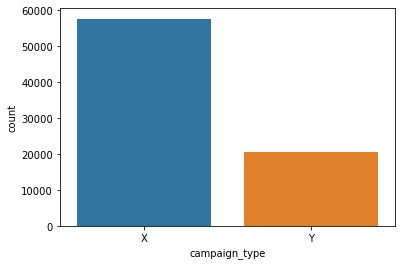

In [227]:
sns.countplot(train['campaign_type'])
# campaign x has the majority among the campaigns conducted

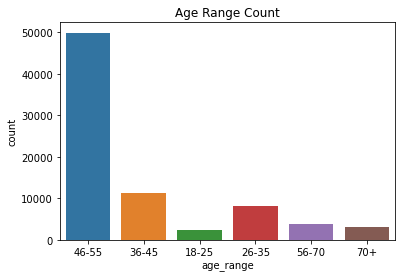

In [228]:
sns.countplot(train['age_range'])
plt.title('Age Range Count')
plt.show()

Text(0.5, 1.0, 'marital status')

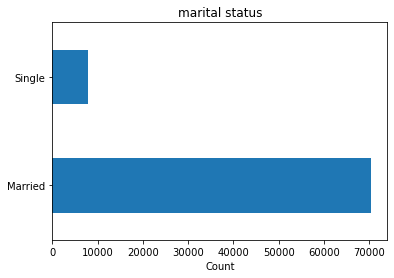

In [229]:
train['marital_status'].value_counts().plot(kind = 'barh')
plt.xlabel('Count')
plt.title("marital status")

<AxesSubplot:xlabel='marital_status', ylabel='count'>

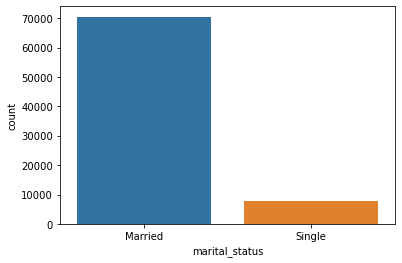

In [230]:
sns.countplot(train['marital_status'])

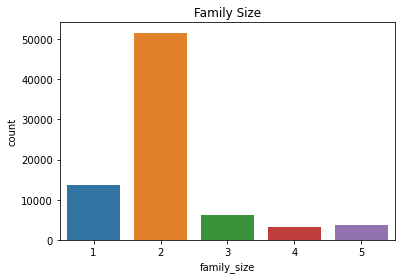

In [231]:
sns.countplot(train['family_size'])
plt.title('Family Size')
plt.show()

<AxesSubplot:xlabel='no_of_children', ylabel='count'>

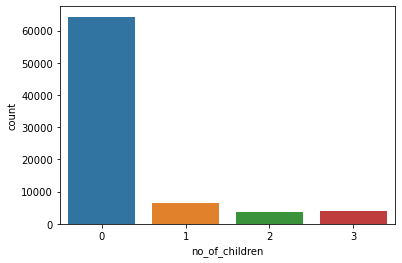

In [232]:
sns.countplot(train['no_of_children'])

In [233]:
df_num = train.select_dtypes(exclude = object)

In [234]:
df_num.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'item_count_x', 'brand', 'Customer_count', 'quantity_x',
       'selling_price_x', 'other_discount_x', 'coupon_discount_x',
       'cust_transactions', 'quantity_mean_x', 'sellingPrice_mean',
       'other_discount_mean_x', 'coupon_discount_mean_x', 'Coupon_utilized_x',
       'total_discount_mean', 'total_discount_sum', 'start_date', 'end_date',
       'diff_d', 'rented', 'income_bracket', 'item_count_y',
       'selling_price_mean', 'quantity_mean_y', 'other_discount_mean_y',
       'coupon_discount_mean_y', 'day', 'month', 'year', 'Coupon_utilized_y',
       'item_id', 'selling_price_y', 'quantity_y', 'other_discount_y',
       'coupon_discount_y'],
      dtype='object')

Text(0.5, 1.0, 'Campaign Count')

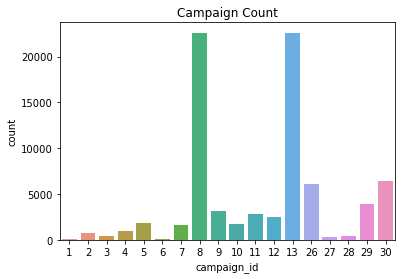

In [235]:
sns.countplot(train['campaign_id'])
plt.title("Campaign Count")

Text(0.5, 1.0, 'Coupon Count')

<Figure size 864x576 with 0 Axes>

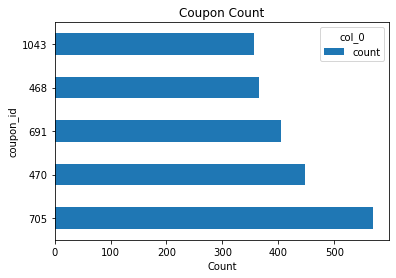

In [236]:
plt.figure(figsize=(12,8))
pd.crosstab(train['coupon_id'],columns ='count').sort_values(by='count',ascending=False).head().plot(kind ='barh')
plt.xlabel("Count")
plt.title("Coupon Count")

In [237]:
train['income_bracket'].value_counts()

5.0     45745
4.0      8753
6.0      4855
2.0      3892
3.0      3882
1.0      3456
8.0      2369
9.0      2019
7.0      1829
12.0      796
10.0      513
11.0      260
Name: income_bracket, dtype: int64

Text(0.5, 1.0, 'Income Bracket')

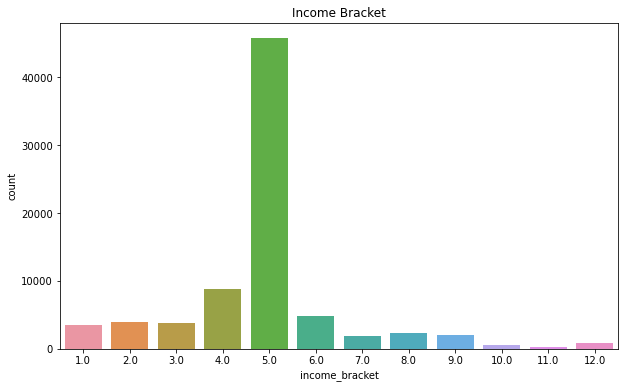

In [238]:
plt.figure(figsize=(10,6))
sns.countplot(train['income_bracket'])
plt.title("Income Bracket")

In [239]:
num_df = train.select_dtypes(exclude =object)
cat_df = train.select_dtypes(include = object)

In [240]:
num_df = num_df.drop(['start_date','end_date','redemption_status'],axis = 1)

In [241]:
cat_df = pd.concat([cat_df,train[['income_bracket']]],axis=1)

In [242]:
num_df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'item_count_x',
       'brand', 'Customer_count', 'quantity_x', 'selling_price_x',
       'other_discount_x', 'coupon_discount_x', 'cust_transactions',
       'quantity_mean_x', 'sellingPrice_mean', 'other_discount_mean_x',
       'coupon_discount_mean_x', 'Coupon_utilized_x', 'total_discount_mean',
       'total_discount_sum', 'diff_d', 'rented', 'income_bracket',
       'item_count_y', 'selling_price_mean', 'quantity_mean_y',
       'other_discount_mean_y', 'coupon_discount_mean_y', 'day', 'month',
       'year', 'Coupon_utilized_y', 'item_id', 'selling_price_y', 'quantity_y',
       'other_discount_y', 'coupon_discount_y'],
      dtype='object')

In [243]:
cat_df.columns

Index(['brand_type', 'category', 'campaign_type', 'age_range',
       'marital_status', 'family_size', 'no_of_children', 'income_bracket'],
      dtype='object')

In [244]:
cat_df.columns

Index(['brand_type', 'category', 'campaign_type', 'age_range',
       'marital_status', 'family_size', 'no_of_children', 'income_bracket'],
      dtype='object')

In [245]:
cat_df['campaign_type'].head()

0    X
1    X
2    Y
3    X
4    X
Name: campaign_type, dtype: object

In [246]:
cat_df['age_range'].value_counts()

46-55    49862
36-45    11210
26-35     8024
56-70     3723
70+       3094
18-25     2456
Name: age_range, dtype: int64

In [247]:
from sklearn.preprocessing import LabelEncoder

In [248]:
le = LabelEncoder()

In [249]:
cat_enc = pd.DataFrame(le.fit_transform(cat_df['campaign_type']),columns = ['campaign_type'])

In [250]:
# age range encoding

In [251]:
from sklearn.preprocessing import OrdinalEncoder
data = cat_df[['age_range']]
encoder = OrdinalEncoder()
result = encoder.fit_transform(data)
print(result)

[[3.]
 [2.]
 [3.]
 ...
 [3.]
 [2.]
 [3.]]


In [252]:
cat_enc['age_range'] = result

In [253]:
cat_enc = pd.concat([cat_enc,pd.get_dummies(cat_df['marital_status'],drop_first=True)],axis=1)

In [254]:
cat_df['family_size']= cat_df['family_size'].astype(object)

In [255]:
cat_df['family_size']= cat_df['family_size'].astype(object)

In [256]:
# family_size
data = cat_df[['family_size']]
encoder = OrdinalEncoder()
result = encoder.fit_transform(data)
print(result)

[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [4.]
 [1.]]


In [257]:
cat_enc['family_size'] = result

In [258]:
data = cat_df[['no_of_children']]
encoder = OrdinalEncoder()
result = encoder.fit_transform(data)
print(result)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [3.]
 [0.]]


In [259]:
cat_enc['no_of_children'] = result

In [260]:
data = cat_df[['income_bracket']]
encoder = OrdinalEncoder()
result = encoder.fit_transform(data)
print(result)

[[4.]
 [2.]
 [6.]
 ...
 [4.]
 [3.]
 [4.]]


In [261]:
cat_enc['income_bracket'] = result

In [262]:
cat_enc

,campaign_type,age_range,Single,family_size,no_of_children,income_bracket
0,0,3.0,0,0.0,0.0,4.0
1,0,2.0,0,1.0,0.0,2.0
2,1,3.0,0,1.0,0.0,6.0
3,0,3.0,0,1.0,0.0,4.0
4,0,3.0,0,1.0,0.0,2.0
...,...,...,...,...,...,...
78364,0,5.0,0,1.0,0.0,0.0
78365,0,5.0,0,1.0,0.0,1.0
78366,0,3.0,0,1.0,0.0,4.0
78367,0,2.0,0,4.0,3.0,3.0


In [263]:
from sklearn.preprocessing import StandardScaler

In [264]:
ss = StandardScaler()

In [265]:
df_num_scaled = ss.fit_transform(num_df)

In [266]:
df_num_scaled = pd.DataFrame(df_num_scaled,columns = num_df.columns)

In [267]:
df_num_scaled.head()

,id,campaign_id,coupon_id,customer_id,item_count_x,brand,Customer_count,quantity_x,selling_price_x,other_discount_x,...,coupon_discount_mean_y,day,month,year,Coupon_utilized_y,item_id,selling_price_y,quantity_y,other_discount_y,coupon_discount_y
0,-1.733196,-0.121514,-1.634613,0.581312,0.071188,0.038761,0.124860,0.128690,0.080786,-0.632939,...,0.455543,-0.521481,0.020219,3.117819,-0.449826,-1.097975,-0.757737,-0.147977,0.625393,0.455543
1,-1.733169,-0.121514,-1.364886,-1.618735,-0.130455,-0.748446,0.207049,-0.160847,-0.163781,0.154508,...,-0.444733,-1.342268,0.448828,-0.320737,-0.165313,-0.984004,-0.354027,-0.534847,0.596124,-0.444733
2,-1.733061,-0.620319,0.208013,-1.275046,-0.024675,-0.370226,-1.168935,-0.153506,-0.130760,0.074390,...,-1.156285,1.354604,-0.836999,-0.320737,1.722817,-0.095029,-0.020984,-0.579545,0.090370,-1.156285
3,-1.733034,-0.121514,0.235289,0.574744,-0.128802,-0.331954,-1.040109,-0.163316,-0.164769,0.155819,...,0.385754,-0.755992,1.306047,-0.320737,-0.423961,-1.208907,-1.170788,-0.583873,1.111016,0.385754
4,-1.732980,-0.745021,1.365715,1.535760,-0.082523,0.378708,0.724126,-0.064398,0.044983,-0.035496,...,0.317642,-1.576779,0.020219,-0.320737,-0.217043,-0.715032,-0.627376,-0.009180,0.529377,0.317642


In [268]:
df = pd.concat([df_num_scaled,cat_enc],axis =1)

In [269]:
df[df['quantity_mean_x'].isnull() == True]

,id,campaign_id,coupon_id,customer_id,item_count_x,brand,Customer_count,quantity_x,selling_price_x,other_discount_x,...,selling_price_y,quantity_y,other_discount_y,coupon_discount_y,campaign_type,age_range,Single,family_size,no_of_children,income_bracket


In [270]:
df.isnull().sum()

id                        0
campaign_id               0
coupon_id                 0
customer_id               0
item_count_x              0
brand                     0
Customer_count            0
quantity_x                0
selling_price_x           0
other_discount_x          0
coupon_discount_x         0
cust_transactions         0
quantity_mean_x           0
sellingPrice_mean         0
other_discount_mean_x     0
coupon_discount_mean_x    0
Coupon_utilized_x         0
total_discount_mean       0
total_discount_sum        0
diff_d                    0
rented                    0
income_bracket            0
item_count_y              0
selling_price_mean        0
quantity_mean_y           0
other_discount_mean_y     0
coupon_discount_mean_y    0
day                       0
month                     0
year                      0
Coupon_utilized_y         0
item_id                   0
selling_price_y           0
quantity_y                0
other_discount_y          0
coupon_discount_y   

In [271]:
df = df.iloc[:,:-1]

In [272]:
df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'item_count_x',
       'brand', 'Customer_count', 'quantity_x', 'selling_price_x',
       'other_discount_x', 'coupon_discount_x', 'cust_transactions',
       'quantity_mean_x', 'sellingPrice_mean', 'other_discount_mean_x',
       'coupon_discount_mean_x', 'Coupon_utilized_x', 'total_discount_mean',
       'total_discount_sum', 'diff_d', 'rented', 'income_bracket',
       'item_count_y', 'selling_price_mean', 'quantity_mean_y',
       'other_discount_mean_y', 'coupon_discount_mean_y', 'day', 'month',
       'year', 'Coupon_utilized_y', 'item_id', 'selling_price_y', 'quantity_y',
       'other_discount_y', 'coupon_discount_y', 'campaign_type', 'age_range',
       'Single', 'family_size', 'no_of_children'],
      dtype='object')

In [273]:
x = df
y = train[['redemption_status']]

In [274]:
x.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'item_count_x',
       'brand', 'Customer_count', 'quantity_x', 'selling_price_x',
       'other_discount_x', 'coupon_discount_x', 'cust_transactions',
       'quantity_mean_x', 'sellingPrice_mean', 'other_discount_mean_x',
       'coupon_discount_mean_x', 'Coupon_utilized_x', 'total_discount_mean',
       'total_discount_sum', 'diff_d', 'rented', 'income_bracket',
       'item_count_y', 'selling_price_mean', 'quantity_mean_y',
       'other_discount_mean_y', 'coupon_discount_mean_y', 'day', 'month',
       'year', 'Coupon_utilized_y', 'item_id', 'selling_price_y', 'quantity_y',
       'other_discount_y', 'coupon_discount_y', 'campaign_type', 'age_range',
       'Single', 'family_size', 'no_of_children'],
      dtype='object')

In [275]:
train.isnull().sum()

id                        0
campaign_id               0
coupon_id                 0
customer_id               0
redemption_status         0
item_count_x              0
brand                     0
brand_type                0
category                  0
Customer_count            0
quantity_x                0
selling_price_x           0
other_discount_x          0
coupon_discount_x         0
cust_transactions         0
quantity_mean_x           0
sellingPrice_mean         0
other_discount_mean_x     0
coupon_discount_mean_x    0
Coupon_utilized_x         0
total_discount_mean       0
total_discount_sum        0
campaign_type             0
start_date                0
end_date                  0
diff_d                    0
age_range                 0
marital_status            0
rented                    0
family_size               0
no_of_children            0
income_bracket            0
item_count_y              0
selling_price_mean        0
quantity_mean_y           0
other_discount_mean_

In [276]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score,cohen_kappa_score,classification_report,confusion_matrix

In [276]:
x.shape,y.shape

((78369, 41), (78369, 1))

In [277]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state = 10, test_size = 0.2)


In [278]:
xtrain.shape,ytrain.shape

((62695, 41), (62695, 1))

In [279]:
xtest.shape,ytest.shape

((15674, 41), (15674, 1))

## Models with all the features

In [280]:
from sklearn.linear_model import LogisticRegression

In [281]:
LR = LogisticRegression()
LR.fit(xtrain,ytrain)       
lr_pred = LR.predict(xtest)

In [282]:
roc_auc_LR = roc_auc_score(ytest,lr_pred)
accuracy_LR = accuracy_score(ytest,lr_pred)
kappa_score_LR = cohen_kappa_score(ytest,lr_pred)  
print('roc_auc:',round(roc_auc_LR,2))
print('accuracy:',round(accuracy_LR,2))
print('kappa_score:',round(kappa_score_LR,2))
print('Classification Report:','\n',classification_report(ytest,lr_pred))

roc_auc: 0.5
accuracy: 0.99
kappa_score: 0.01
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.11      0.01      0.01       158

    accuracy                           0.99     15674
   macro avg       0.55      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [283]:
confusion_matrix(ytest,lr_pred)

array([[15508,     8],
       [  157,     1]], dtype=int64)

# KNN CLASSIFIER

In [284]:
from sklearn.metrics import f1_score

In [285]:
knn = KNeighborsClassifier()
knn.fit(xtrain,ytrain)
knn_pred = knn.predict(xtest)

In [286]:
roc_auc = roc_auc_score(ytest,knn_pred)
accuracy_ = accuracy_score(ytest,knn_pred)
kappa_score_ = cohen_kappa_score(ytest,knn_pred)  
f1_ = f1_score(ytest,knn_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,knn_pred))

roc_auc: 0.5154683120078579
accuracy: 0.9895368125558249
kappa_score: 0.05572069854750883
f1 0.0574712643678161
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.31      0.03      0.06       158

    accuracy                           0.99     15674
   macro avg       0.65      0.52      0.53     15674
weighted avg       0.98      0.99      0.99     15674



In [287]:
confusion_matrix(ytest,knn_pred)

array([[15505,    11],
       [  153,     5]], dtype=int64)

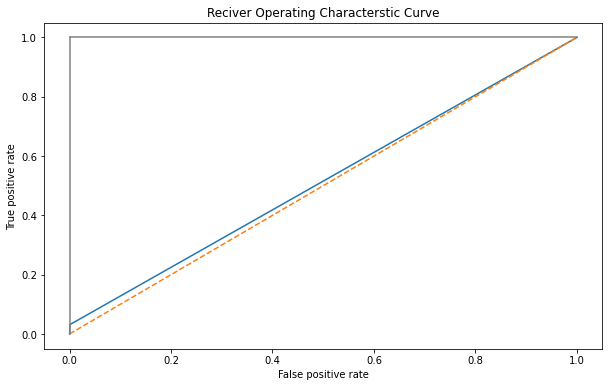

In [288]:
fpr,tpr,thr = roc_curve(ytest,knn_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# Decision Tree

In [289]:
dt = DecisionTreeClassifier()
dt.fit(xtrain,ytrain)
dt_pred = dt.predict(xtest)

In [290]:
roc_auc = roc_auc_score(ytest,dt_pred)
accuracy_ = accuracy_score(ytest,dt_pred)
kappa_score_ = cohen_kappa_score(ytest,dt_pred)  
f1_ = f1_score(ytest,dt_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,dt_pred))

roc_auc: 0.5773158617808974
accuracy: 0.9817532218961337
kappa_score: 0.14466281951378102
f1 0.15384615384615383
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15516
           1       0.14      0.16      0.15       158

    accuracy                           0.98     15674
   macro avg       0.57      0.58      0.57     15674
weighted avg       0.98      0.98      0.98     15674



In [291]:
confusion = confusion_matrix(ytest,dt_pred)
confusion

array([[15362,   154],
       [  132,    26]], dtype=int64)

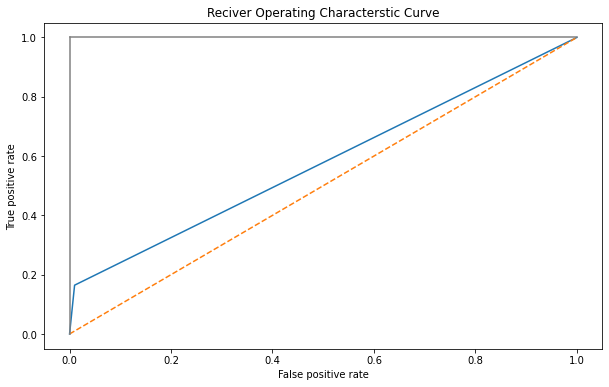

In [292]:
fpr,tpr,thr = roc_curve(ytest,dt_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# Ada Boost

In [297]:
from sklearn.ensemble import AdaBoostClassifier
ad = AdaBoostClassifier()
ad.fit(xtrain,ytrain)
aad_pred = ad.predict(xtest)

In [298]:
roc_auc = roc_auc_score(ytest,aad_pred)
accuracy_ = accuracy_score(ytest,aad_pred)
kappa_score_ = cohen_kappa_score(ytest,aad_pred)  
f1_ = f1_score(ytest,aad_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,aad_pred))

roc_auc: 0.5060713155224007
accuracy: 0.9895368125558249
kappa_score: 0.022636642647045457
f1 0.023809523809523808
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.20      0.01      0.02       158

    accuracy                           0.99     15674
   macro avg       0.60      0.51      0.51     15674
weighted avg       0.98      0.99      0.98     15674



In [299]:
confusion = confusion_matrix(ytest,aad_pred)
confusion

array([[15508,     8],
       [  156,     2]], dtype=int64)

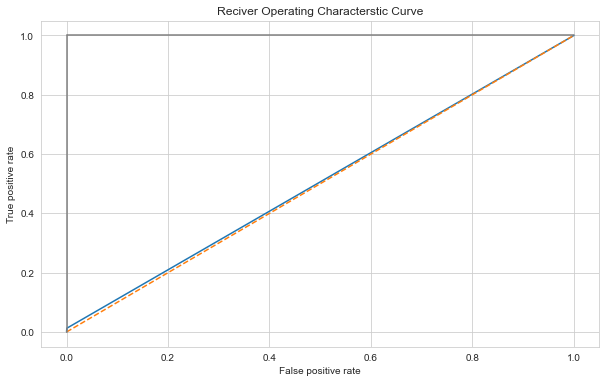

In [300]:
fpr,tpr,thr = roc_curve(ytest,aad_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [301]:
xtrain.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'item_count_x',
       'brand', 'Customer_count', 'quantity_x', 'selling_price_x',
       'other_discount_x', 'coupon_discount_x', 'cust_transactions',
       'quantity_mean_x', 'sellingPrice_mean', 'other_discount_mean_x',
       'coupon_discount_mean_x', 'Coupon_utilized_x', 'total_discount_mean',
       'total_discount_sum', 'diff_d', 'rented', 'income_bracket',
       'item_count_y', 'selling_price_mean', 'quantity_mean_y',
       'other_discount_mean_y', 'coupon_discount_mean_y', 'day', 'month',
       'year', 'Coupon_utilized_y', 'item_id', 'selling_price_y', 'quantity_y',
       'other_discount_y', 'coupon_discount_y', 'campaign_type', 'age_range',
       'Single', 'family_size', 'no_of_children'],
      dtype='object')

# Xg boost

In [302]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(xtrain,ytrain)
xg_p = xg.predict(xtest)

In [303]:
roc_auc = roc_auc_score(ytest,xg_p)
accuracy_ = accuracy_score(ytest,xg_p)
kappa_score_ = cohen_kappa_score(ytest,xg_p)  
f1_ = f1_score(ytest,xg_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,xg_p))

roc_auc: 0.5593854118737376
accuracy: 0.9896644124027051
kappa_score: 0.18655607125740992
f1 0.19
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.45      0.12      0.19       158

    accuracy                           0.99     15674
   macro avg       0.72      0.56      0.59     15674
weighted avg       0.99      0.99      0.99     15674



In [304]:
confusion = confusion_matrix(ytest,xg_p)
confusion

array([[15493,    23],
       [  139,    19]], dtype=int64)

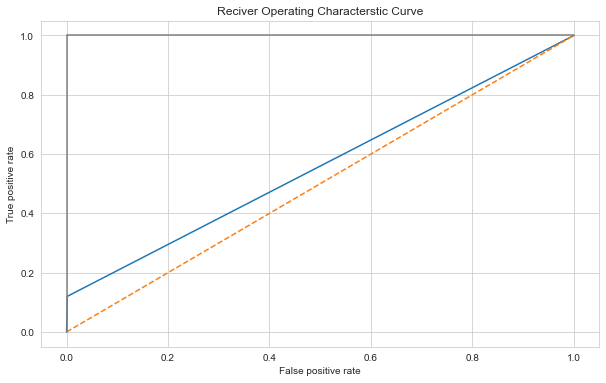

In [305]:
fpr,tpr,thr = roc_curve(ytest,xg_p)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# Naive Bayes

In [306]:
nb = GaussianNB()
nb.fit(xtrain,ytrain)
nb_pred = nb.predict(xtest)

In [307]:
roc_auc = roc_auc_score(ytest,nb_pred)
accuracy_ = accuracy_score(ytest,nb_pred)
kappa_score_ = cohen_kappa_score(ytest,nb_pred)  
f1_ = f1_score(ytest,nb_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,nb_pred))

roc_auc: 0.6100317842586338
accuracy: 0.9473012632384841
kappa_score: 0.07692902205008123
f1 0.09230769230769231
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     15516
           1       0.06      0.27      0.09       158

    accuracy                           0.95     15674
   macro avg       0.52      0.61      0.53     15674
weighted avg       0.98      0.95      0.96     15674



In [308]:
confusion = confusion_matrix(ytest,nb_pred)
confusion

array([[14806,   710],
       [  116,    42]], dtype=int64)

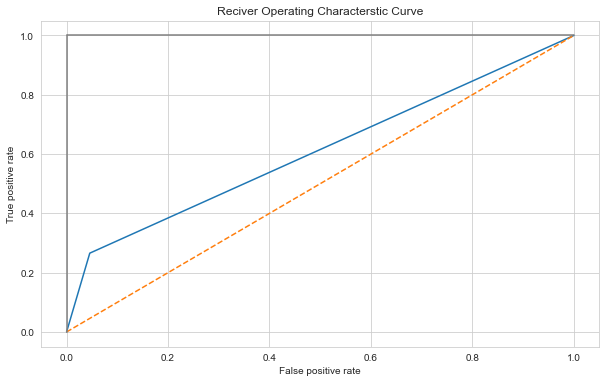

In [309]:
fpr,tpr,thr = roc_curve(ytest,nb_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# Lgbm

In [310]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [311]:
import lightgbm
from lightgbm import LGBMClassifier

In [312]:
LM = LGBMClassifier()
LM.fit(xtrain, ytrain)
LM_pred = LM.predict(xtest)

In [313]:
roc_auc = roc_auc_score(ytest,LM_pred)
accuracy_ = accuracy_score(ytest,LM_pred)
kappa_score_ = cohen_kappa_score(ytest,LM_pred)  
f1_ = f1_score(ytest,LM_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,LM_pred))

roc_auc: 0.5558019325090311
accuracy: 0.9887712134745438
kappa_score: 0.16552605341361182
f1 0.16981132075471697
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.33      0.11      0.17       158

    accuracy                           0.99     15674
   macro avg       0.66      0.56      0.58     15674
weighted avg       0.98      0.99      0.99     15674



In [314]:
confusion = confusion_matrix(ytest,LM_pred)
confusion

array([[15480,    36],
       [  140,    18]], dtype=int64)

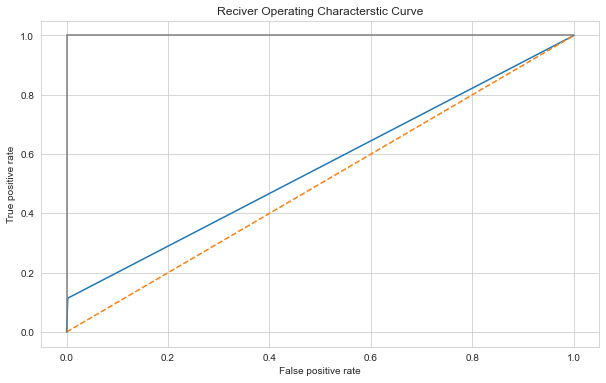

In [315]:
fpr,tpr,thr = roc_curve(ytest,LM_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# Boosted Logitic Regression

In [316]:
lr = LogisticRegression()
Lr_boost = AdaBoostClassifier(base_estimator=lr,n_estimators=100,learning_rate=0.01,random_state=1)
Lr_boost.fit(xtrain,ytrain)
lr_bt_pred = Lr_boost.predict(xtest)

In [317]:
roc_auc = roc_auc_score(ytest,lr_bt_pred)
accuracy_ = accuracy_score(ytest,lr_bt_pred)
kappa_score_ = cohen_kappa_score(ytest,lr_bt_pred)  
f1_ = f1_score(ytest,lr_bt_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,lr_bt_pred))

roc_auc: 0.5
accuracy: 0.9899196120964655
kappa_score: 0.0
f1 0.0
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.00      0.00      0.00       158

    accuracy                           0.99     15674
   macro avg       0.49      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [318]:
confusion = confusion_matrix(ytest,lr_bt_pred)
confusion

array([[15516,     0],
       [  158,     0]], dtype=int64)

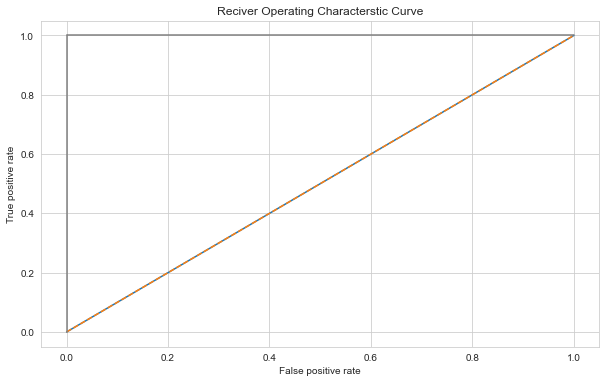

In [319]:
fpr,tpr,thr = roc_curve(ytest,lr_bt_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# DT Boosted

In [320]:
dt = DecisionTreeClassifier()
dt_b = AdaBoostClassifier(base_estimator=dt,n_estimators=100,learning_rate=0.01,random_state=1)
dt_b.fit(xtrain,ytrain)
dt_b_p = dt_b.predict(xtest)

In [321]:
roc_auc = roc_auc_score(ytest,dt_b_p)
accuracy_ = accuracy_score(ytest,dt_b_p)
kappa_score_ = cohen_kappa_score(ytest,dt_b_p)  
f1_ = f1_score(ytest,dt_b_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,dt_b_p))

roc_auc: 0.5804804187429228
accuracy: 0.9818170218195739
kappa_score: 0.1501439228048681
f1 0.15929203539823011
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15516
           1       0.15      0.17      0.16       158

    accuracy                           0.98     15674
   macro avg       0.57      0.58      0.58     15674
weighted avg       0.98      0.98      0.98     15674



In [322]:
confusion = confusion_matrix(ytest,dt_b_p)
confusion

array([[15362,   154],
       [  131,    27]], dtype=int64)

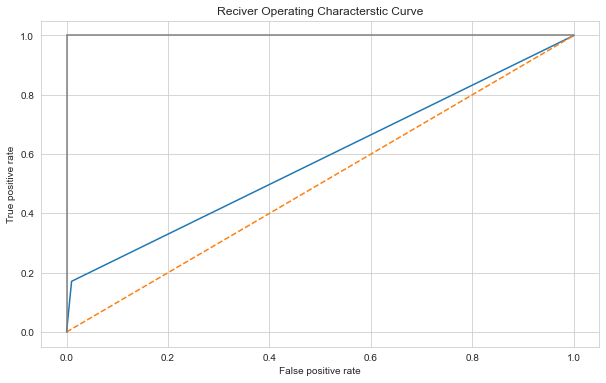

In [323]:
fpr,tpr,thr = roc_curve(ytest,dt_b_p)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# NB Boosted

In [324]:
nb = GaussianNB()
nb_Boost = AdaBoostClassifier(base_estimator=nb,n_estimators=100,learning_rate=0.01,random_state=1)
nb_Boost.fit(xtrain,ytrain)
nb_b_p = nb_Boost.predict(xtest)

In [325]:
roc_auc = roc_auc_score(ytest,nb_b_p)
accuracy_ = accuracy_score(ytest,nb_b_p)
kappa_score_ = cohen_kappa_score(ytest,nb_b_p)  
f1_ = f1_score(ytest,dt_b_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,nb_b_p))

roc_auc: 0.5239630140875405
accuracy: 0.9877504146995023
kappa_score: 0.07242774609233404
f1 0.15929203539823011
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.16      0.05      0.08       158

    accuracy                           0.99     15674
   macro avg       0.58      0.52      0.54     15674
weighted avg       0.98      0.99      0.98     15674



In [326]:
confusion = confusion_matrix(ytest,nb_b_p)
confusion

array([[15474,    42],
       [  150,     8]], dtype=int64)

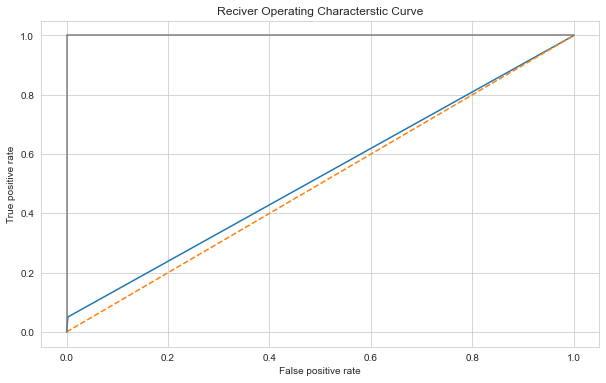

In [327]:
fpr,tpr,thr = roc_curve(ytest,nb_b_p)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# RF Boosted

In [328]:
rf = RandomForestClassifier()
rf_Boost = AdaBoostClassifier(base_estimator=rf,n_estimators=100,learning_rate=0.01,random_state=1)
rf_Boost.fit(xtrain,ytrain)
rf_b_p = rf_Boost.predict(xtest)

In [329]:
roc_auc = roc_auc_score(ytest,rf_b_p)
accuracy_ = accuracy_score(ytest,rf_b_p)
kappa_score_ = cohen_kappa_score(ytest,rf_b_p)  
f1_ = f1_score(ytest,rf_b_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,rf_b_p))

roc_auc: 0.5376846603424476
accuracy: 0.9901110118667857
kappa_score: 0.13202525178545277
f1 0.13407821229050282
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     15516
           1       0.57      0.08      0.13       158

    accuracy                           0.99     15674
   macro avg       0.78      0.54      0.56     15674
weighted avg       0.99      0.99      0.99     15674



In [330]:
confusion = confusion_matrix(ytest,rf_b_p)
confusion

array([[15507,     9],
       [  146,    12]], dtype=int64)

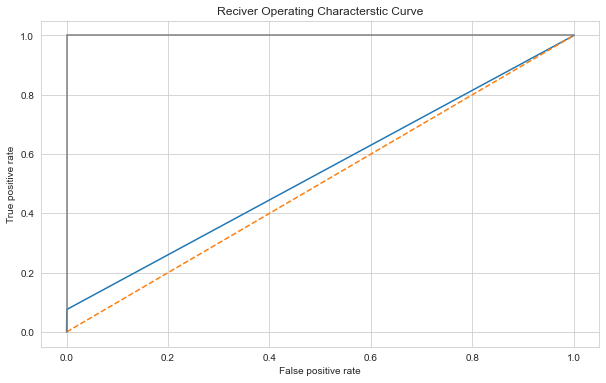

In [331]:
fpr,tpr,thr = roc_curve(ytest,rf_b_p)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# svm

In [332]:
#from sklearn import svm
#regr = svm.SVC()
#regr.fit(xtrain1,ytrain1)
#svm_s_p = regr.predict(xtest1)

### Random Forest

In [344]:
rf = RandomForestClassifier()
rf.fit(xtrain,ytrain)
rf_pred = rf.predict(xtest)

In [345]:
roc_auc = roc_auc_score(ytest,rf_pred)
accuracy_ = accuracy_score(ytest,rf_pred)
kappa_score_ = cohen_kappa_score(ytest,rf_pred)  
f1_ = f1_score(ytest,rf_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,rf_pred))

roc_auc: 0.540849217304473
accuracy: 0.9901748117902258
kappa_score: 0.14233106686829866
f1 0.14444444444444443
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     15516
           1       0.59      0.08      0.14       158

    accuracy                           0.99     15674
   macro avg       0.79      0.54      0.57     15674
weighted avg       0.99      0.99      0.99     15674



In [346]:
confusion = confusion_matrix(ytest,rf_pred)
confusion

array([[15507,     9],
       [  145,    13]], dtype=int64)

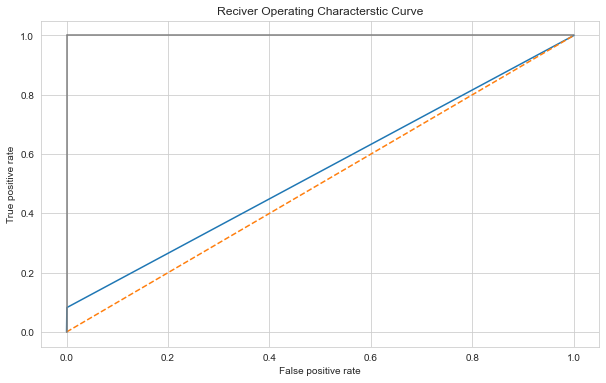

In [347]:
fpr,tpr,thr = roc_curve(ytest,rf_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# Models with Significant Features

In [348]:
feature_imp = pd.DataFrame(rf.feature_importances_,index = xtrain.columns,columns =['Vals']).sort_values(by = 'Vals',ascending=False)

In [349]:
top_15 = feature_imp.head(15)
top_15.index

Index(['id', 'Coupon_utilized_y', 'coupon_discount_y',
       'coupon_discount_mean_y', 'customer_id', 'selling_price_y',
       'other_discount_mean_y', 'quantity_y', 'Coupon_utilized_x',
       'quantity_mean_y', 'other_discount_y', 'coupon_discount_x',
       'selling_price_mean', 'total_discount_sum', 'item_id'],
      dtype='object')

In [350]:
x_2 = x[top_15.index]
y_2 = y

In [351]:
xtrain_2,xtest_2,ytrain_2,ytest_2 = train_test_split(x_2,y_2,test_size=0.20,random_state=123)

## Random Forest

In [352]:
re_imp = RandomForestClassifier()
re_imp.fit(xtrain_2,ytrain_2)
rf_imp_pred = re_imp.predict(xtest_2)

In [353]:
roc_auc = roc_auc_score(ytest_2,rf_imp_pred)
accuracy_ = accuracy_score(ytest_2,rf_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,rf_imp_pred)  
f1_ = f1_score(ytest_2,rf_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,rf_imp_pred))

roc_auc: 0.5465897275308739
accuracy: 0.9896644124027051
kappa_score: 0.15329749369271684
f1 0.15625
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.45      0.09      0.16       159

    accuracy                           0.99     15674
   macro avg       0.72      0.55      0.58     15674
weighted avg       0.99      0.99      0.99     15674



In [354]:
confusion = confusion_matrix(ytest_2,rf_imp_pred)
confusion

array([[15497,    18],
       [  144,    15]], dtype=int64)

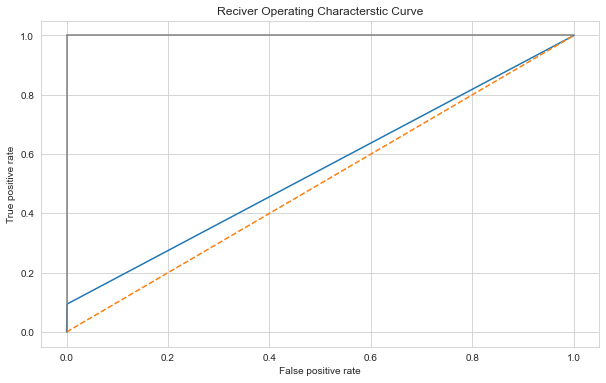

In [355]:
fpr,tpr,thr = roc_curve(ytest_2,rf_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Logistic Regression

In [356]:
LR_imp = LogisticRegression()
LR_imp.fit(xtrain_2,ytrain_2)       
LR_imp_pred = LR_imp.predict(xtest_2)

In [357]:
roc_auc = roc_auc_score(ytest_2,LR_imp_pred)
accuracy_ = accuracy_score(ytest_2,LR_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,LR_imp_pred)  
print('roc_auc:',round(roc_auc,2))
print('accuracy:',round(accuracy_,2))
print('kappa_score:',round(kappa_score_,2))
print('Classification Report:','\n',classification_report(ytest_2,LR_imp_pred))

roc_auc: 0.5
accuracy: 0.99
kappa_score: 0.01
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.33      0.01      0.01       159

    accuracy                           0.99     15674
   macro avg       0.66      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [358]:
confusion_matrix(ytest_2,LR_imp_pred)

array([[15513,     2],
       [  158,     1]], dtype=int64)

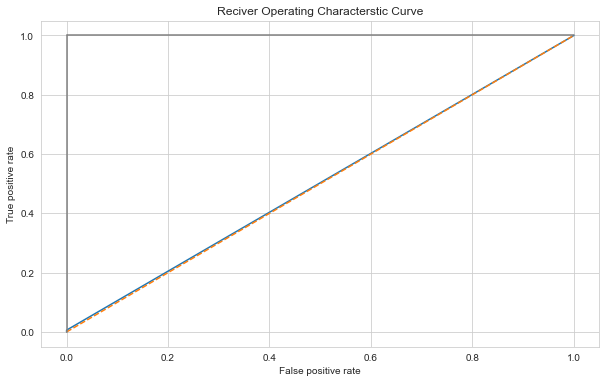

In [359]:
fpr,tpr,thr = roc_curve(ytest_2,LR_imp_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## KNN Classifier

In [360]:
knn_imp = KNeighborsClassifier()
knn_imp.fit(xtrain_2,ytrain_2)
knn_imp_pred = knn_imp.predict(xtest_2)

In [361]:
roc_auc = roc_auc_score(ytest_2,knn_imp_pred)
accuracy_ = accuracy_score(ytest_2,knn_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,knn_imp_pred)  
f1_ = f1_score(ytest_2,knn_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,knn_imp_pred))

roc_auc: 0.5217547635986275
accuracy: 0.9897920122495854
kappa_score: 0.07884867838675103
f1 0.08045977011494253
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.47      0.04      0.08       159

    accuracy                           0.99     15674
   macro avg       0.73      0.52      0.54     15674
weighted avg       0.98      0.99      0.99     15674



In [362]:
confusion_matrix(ytest_2,knn_imp_pred)

array([[15507,     8],
       [  152,     7]], dtype=int64)

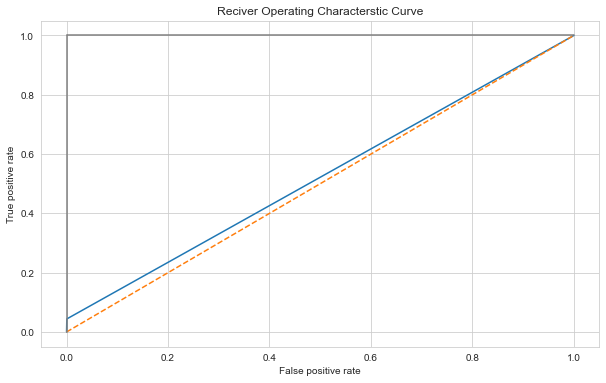

In [363]:
fpr,tpr,thr = roc_curve(ytest_2,knn_imp_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Decision Tree

In [364]:
dt_imp = DecisionTreeClassifier()
dt_imp.fit(xtrain_2,ytrain_2)
dt_imp_pred = dt_imp.predict(xtest_2)

In [365]:
roc_auc = roc_auc_score(ytest_2,dt_imp_pred)
accuracy_ = accuracy_score(ytest_2,dt_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,dt_imp_pred)  
f1_ = f1_score(ytest_2,dt_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,dt_imp_pred))

roc_auc: 0.5827973334792663
accuracy: 0.9812428225086129
kappa_score: 0.15059568728085915
f1 0.15999999999999998
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15515
           1       0.15      0.18      0.16       159

    accuracy                           0.98     15674
   macro avg       0.57      0.58      0.58     15674
weighted avg       0.98      0.98      0.98     15674



In [366]:
confusion = confusion_matrix(ytest_2,dt_imp_pred)
confusion

array([[15352,   163],
       [  131,    28]], dtype=int64)

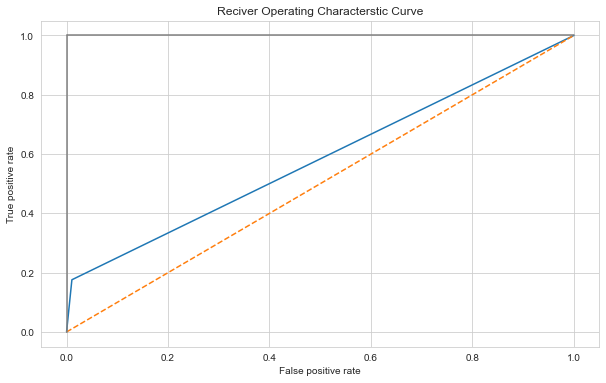

In [367]:
fpr,tpr,thr = roc_curve(ytest_2,dt_imp_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## AdaBoost

In [368]:
ad_imp = AdaBoostClassifier()
ad_imp.fit(xtrain_2,ytrain_2)
aad_imp_pred = ad_imp.predict(xtest_2)

In [369]:
roc_auc = roc_auc_score(ytest_2,aad_imp_pred)
accuracy_ = accuracy_score(ytest_2,aad_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,aad_imp_pred)  
f1_ = f1_score(ytest_2,aad_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,aad_imp_pred))

roc_auc: 0.4999677731227844
accuracy: 0.9897920122495854
kappa_score: -0.00012681842871153926
f1 0.0
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.00      0.00      0.00       159

    accuracy                           0.99     15674
   macro avg       0.49      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [370]:
confusion = confusion_matrix(ytest,aad_imp_pred)
confusion

array([[15515,     1],
       [  158,     0]], dtype=int64)

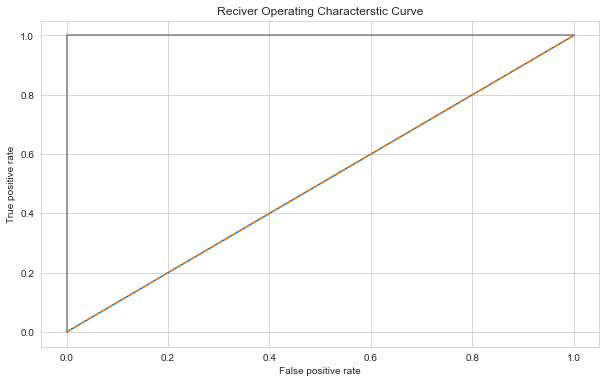

In [371]:
fpr,tpr,thr = roc_curve(ytest,aad_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## XG-Boost

In [372]:
xg_imp = XGBClassifier()
xg_imp.fit(xtrain_2,ytrain_2)
xg_imp_pred = xg_imp.predict(xtest_2)

In [373]:
roc_auc = roc_auc_score(ytest_2,xg_imp_pred)
accuracy_ = accuracy_score(ytest_2,xg_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,xg_imp_pred)  
f1_ = f1_score(ytest_2,xg_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,xg_imp_pred))

roc_auc: 0.5465252737764428
accuracy: 0.9895368125558249
kappa_score: 0.1515335556269981
f1 0.15463917525773196
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.43      0.09      0.15       159

    accuracy                           0.99     15674
   macro avg       0.71      0.55      0.57     15674
weighted avg       0.99      0.99      0.99     15674



In [374]:
confusion = confusion_matrix(ytest_2,xg_imp_pred)
confusion

array([[15495,    20],
       [  144,    15]], dtype=int64)

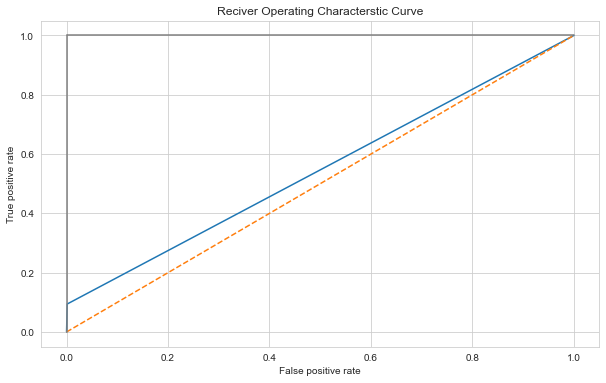

In [375]:
fpr,tpr,thr = roc_curve(ytest_2,xg_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Naive Bayes

In [376]:
nb_imp = GaussianNB()
nb_imp.fit(xtrain_2,ytrain_2)
nb_imp_pred = nb_imp.predict(xtest_2)

In [377]:
roc_auc = roc_auc_score(ytest_2,nb_imp_pred)
accuracy_ = accuracy_score(ytest_2,nb_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,nb_imp_pred)  
f1_ = f1_score(ytest_2,nb_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,nb_imp_pred))

roc_auc: 0.6632064324036184
accuracy: 0.9370932754880694
kappa_score: 0.09437123095737998
f1 0.11010830324909748
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.94      0.97     15515
           1       0.06      0.38      0.11       159

    accuracy                           0.94     15674
   macro avg       0.53      0.66      0.54     15674
weighted avg       0.98      0.94      0.96     15674



In [378]:
confusion = confusion_matrix(ytest_2,nb_imp_pred)
confusion

array([[14627,   888],
       [   98,    61]], dtype=int64)

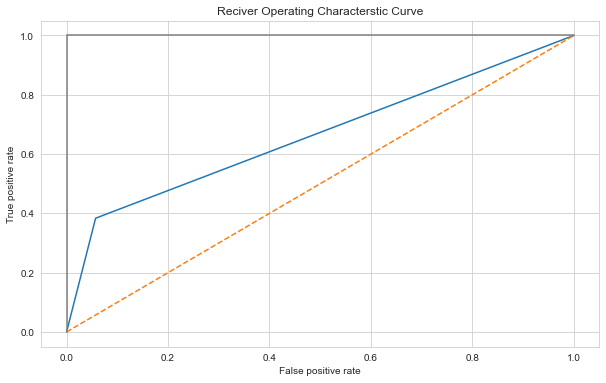

In [379]:
fpr,tpr,thr = roc_curve(ytest_2,nb_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Logistic Regression Boosted

In [380]:
lr = LogisticRegression()
Lr_boost_imp = AdaBoostClassifier(base_estimator=lr,n_estimators=100,learning_rate=0.01,random_state=1)
Lr_boost_imp.fit(xtrain_2,ytrain_2)
lr_bt_imp_pred = Lr_boost_imp.predict(xtest_2)

In [381]:
roc_auc = roc_auc_score(ytest_2,lr_bt_imp_pred)
accuracy_ = accuracy_score(ytest_2,lr_bt_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,lr_bt_imp_pred)  
f1_ = f1_score(ytest_2,lr_bt_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,lr_bt_imp_pred))

roc_auc: 0.5
accuracy: 0.9898558121730254
kappa_score: 0.0
f1 0.0
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.00      0.00      0.00       159

    accuracy                           0.99     15674
   macro avg       0.49      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [382]:
confusion = confusion_matrix(ytest_2,lr_bt_imp_pred)
confusion

array([[15515,     0],
       [  159,     0]], dtype=int64)

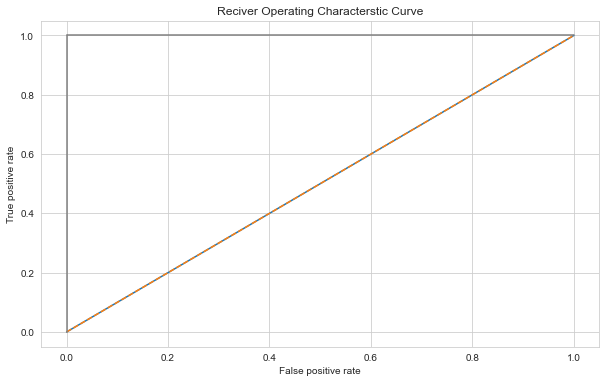

In [383]:
fpr,tpr,thr = roc_curve(ytest_2,lr_bt_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## DT Boosted

In [384]:
dt = DecisionTreeClassifier()
dt_boost_imp = AdaBoostClassifier(base_estimator=dt,n_estimators=100,learning_rate=0.01,random_state=1)
dt_boost_imp.fit(xtrain_2,ytrain_2)
dt_bt_imp_pred = dt_boost_imp.predict(xtest_2)

In [385]:
roc_auc = roc_auc_score(ytest_2,dt_bt_imp_pred)
accuracy_ = accuracy_score(ytest_2,dt_bt_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,dt_bt_imp_pred)  
f1_ = f1_score(ytest_2,dt_bt_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,dt_bt_imp_pred))

roc_auc: 0.5895055910591698
accuracy: 0.9821998213602143
kappa_score: 0.1680286653250248
f1 0.17699115044247787
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15515
           1       0.17      0.19      0.18       159

    accuracy                           0.98     15674
   macro avg       0.58      0.59      0.58     15674
weighted avg       0.98      0.98      0.98     15674



In [386]:
confusion = confusion_matrix(ytest_2,dt_bt_imp_pred)
confusion

array([[15365,   150],
       [  129,    30]], dtype=int64)

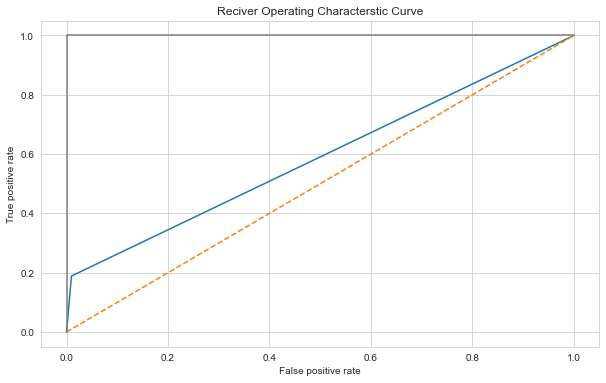

In [387]:
fpr,tpr,thr = roc_curve(ytest_2,dt_bt_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## NB Boosted

In [388]:
nb = GaussianNB()
nb_Boost_imp = AdaBoostClassifier(base_estimator=nb,n_estimators=100,learning_rate=0.01,random_state=1)
nb_Boost_imp.fit(xtrain_2,ytrain_2)
nb_bt_imp_pred = nb_Boost_imp.predict(xtest_2)

In [389]:
roc_auc = roc_auc_score(ytest_2,nb_bt_imp_pred)
accuracy_ = accuracy_score(ytest_2,nb_bt_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,nb_bt_imp_pred)  
f1_ = f1_score(ytest_2,nb_bt_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,nb_bt_imp_pred))

roc_auc: 0.5186423363877928
accuracy: 0.9897920122495854
kappa_score: 0.06833881047360968
f1 0.06976744186046512
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.46      0.04      0.07       159

    accuracy                           0.99     15674
   macro avg       0.73      0.52      0.53     15674
weighted avg       0.98      0.99      0.99     15674



In [390]:
confusion = confusion_matrix(ytest_2,nb_bt_imp_pred)
confusion

array([[15508,     7],
       [  153,     6]], dtype=int64)

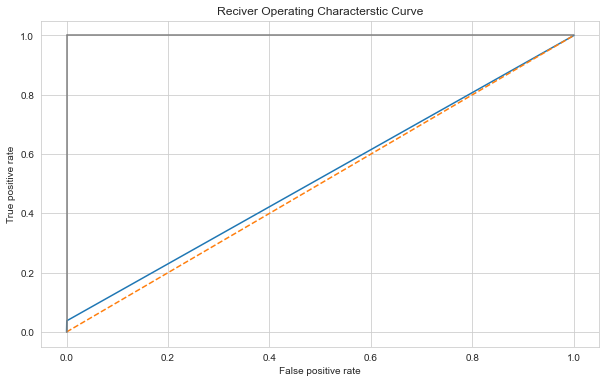

In [391]:
fpr,tpr,thr = roc_curve(ytest_2,nb_bt_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## RF-Boosted

In [392]:
rf = RandomForestClassifier()
rf_Boost_imp = AdaBoostClassifier(base_estimator=rf,n_estimators=100,learning_rate=0.01,random_state=1)
rf_Boost_imp.fit(xtrain_2,ytrain_2)
rf_bt_imp_pred = rf_Boost_imp.predict(xtest_2)

In [393]:
roc_auc = roc_auc_score(ytest_2,rf_bt_imp_pred)
accuracy_ = accuracy_score(ytest_2,rf_bt_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,rf_bt_imp_pred)  
f1_ = f1_score(ytest_2,rf_bt_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,rf_bt_imp_pred))

roc_auc: 0.5434773003200392
accuracy: 0.9896644124027051
kappa_score: 0.14453665889316147
f1 0.14736842105263154
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.45      0.09      0.15       159

    accuracy                           0.99     15674
   macro avg       0.72      0.54      0.57     15674
weighted avg       0.99      0.99      0.99     15674



In [394]:
confusion = confusion_matrix(ytest_2,rf_bt_imp_pred)
confusion

array([[15498,    17],
       [  145,    14]], dtype=int64)

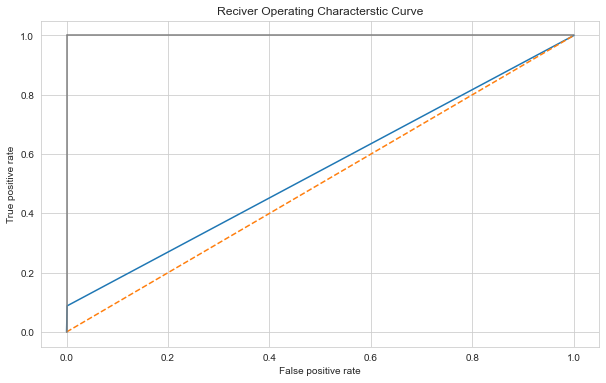

In [395]:
fpr,tpr,thr = roc_curve(ytest_2,rf_bt_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Light GBM

In [396]:
LM_imp = LGBMClassifier()
LM_imp.fit(xtrain_2, ytrain_2)
LM_imp_pred = LM_imp.predict(xtest_2)

In [397]:
roc_auc = roc_auc_score(ytest_2,LM_imp_pred)
accuracy_ = accuracy_score(ytest_2,LM_imp_pred)
kappa_score_ = cohen_kappa_score(ytest_2,LM_imp_pred)  
f1_ = f1_score(ytest_2,LM_imp_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,LM_imp_pred))

roc_auc: 0.5587493944792724
accuracy: 0.9890902130917443
kappa_score: 0.17782762151507092
f1 0.18181818181818182
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.38      0.12      0.18       159

    accuracy                           0.99     15674
   macro avg       0.69      0.56      0.59     15674
weighted avg       0.98      0.99      0.99     15674



In [398]:
confusion = confusion_matrix(ytest_2,LM_imp_pred)
confusion

array([[15484,    31],
       [  140,    19]], dtype=int64)

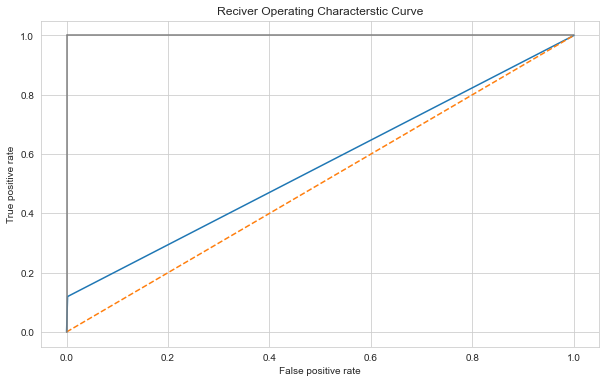

In [399]:
fpr,tpr,thr = roc_curve(ytest_2,LM_imp_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Smote Models

In [277]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x,y)

print('Original dataset shape',len(x))
print('Resampled dataset shape',len(y_smote))



Original dataset shape 78369
Resampled dataset shape 155280


In [278]:
x_smote.shape

(155280, 41)

In [279]:
y_smote.value_counts()

redemption_status
0                    77640
1                    77640
dtype: int64

In [280]:
sm_data = pd.concat([x_smote,y_smote],axis =1)

In [281]:
red_1 = sm_data[sm_data['redemption_status']==1]
red_0 = sm_data[sm_data['redemption_status']==0]

In [282]:
red_1.shape,"  ",red_0.shape

((77640, 42), '  ', (77640, 42))

In [283]:
red_1 = red_1.iloc[:40000,:]

In [284]:
prop_smote = pd.concat([red_1,red_0],axis=0)

<AxesSubplot:xlabel='redemption_status', ylabel='count'>

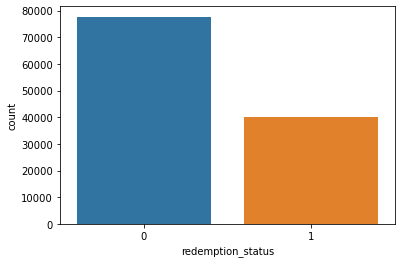

In [285]:
sns.countplot(prop_smote['redemption_status'])

In [286]:
xs_ = prop_smote.drop('redemption_status',axis=1)
ys_ = prop_smote['redemption_status']

In [287]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(xs_,ys_,random_state = 10, test_size = 0.3)

## Logistic Regression SMOTE

In [297]:
LR = LogisticRegression()
LR.fit(xtrain1,ytrain1)       
lr_pred = LR.predict(xtest1)

In [298]:
roc_auc_LR = roc_auc_score(ytest1,lr_pred)
accuracy_LR = accuracy_score(ytest1,lr_pred)
kappa_score_LR = cohen_kappa_score(ytest1,lr_pred)  
print('roc_auc:',round(roc_auc_LR,2))
print('accuracy:',round(accuracy_LR,2))
print('kappa_score:',round(kappa_score_LR,2))
print('Classification Report:','\n',classification_report(ytest1,lr_pred))

roc_auc: 0.82
accuracy: 0.85
kappa_score: 0.65
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     23353
           1       0.80      0.73      0.77     11939

    accuracy                           0.85     35292
   macro avg       0.84      0.82      0.83     35292
weighted avg       0.85      0.85      0.85     35292



In [299]:
confusion = confusion_matrix(ytest1,lr_pred)
confusion

array([[21215,  2138],
       [ 3203,  8736]], dtype=int64)

## Random Forest SMOTE

In [302]:
from sklearn.metrics import f1_score

In [300]:
rf_s = RandomForestClassifier()
rf_s.fit(xtrain1,ytrain1)
rf_s_p = rf_s.predict(xtest1)

In [303]:
roc_auc = roc_auc_score(ytest1,rf_s_p)
accuracy_ = accuracy_score(ytest1,rf_s_p)
kappa_score_ = cohen_kappa_score(ytest1,rf_s_p)  
f1_ = f1_score(ytest1,rf_s_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest1,rf_s_p))

roc_auc: 0.993576876448916
accuracy: 0.9939646378782727
kappa_score: 0.9865277616719699
f1 0.9910912208791668
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     23353
           1       0.99      0.99      0.99     11939

    accuracy                           0.99     35292
   macro avg       0.99      0.99      0.99     35292
weighted avg       0.99      0.99      0.99     35292



In [304]:
confusion = confusion_matrix(ytest1,rf_s_p)
confusion

array([[23231,   122],
       [   91, 11848]], dtype=int64)

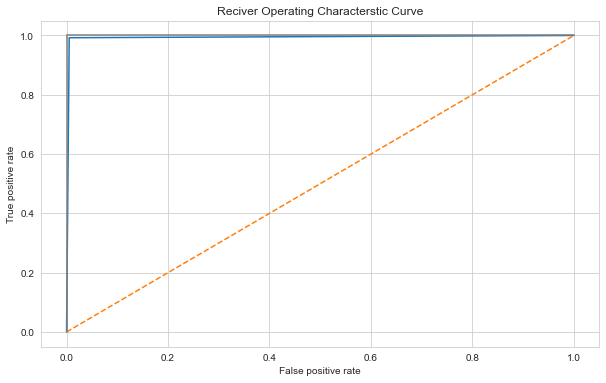

In [305]:
fpr,tpr,thr = roc_curve(ytest1,rf_s_p)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## NaiveBayes SMOTE

In [307]:
nb_s = GaussianNB()
nb_s.fit(xtrain1,ytrain1)
nb_s_p = nb_s.predict(xtest1)

In [308]:
roc_auc = roc_auc_score(ytest1,nb_s_p)
accuracy_ = accuracy_score(ytest1,nb_s_p)
kappa_score_ = cohen_kappa_score(ytest1,nb_s_p)  
f1_ = f1_score(ytest1,nb_s_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest1,nb_s_p))

roc_auc: 0.6650795499741767
accuracy: 0.7558653519211153
kappa_score: 0.377123656058139
f1 0.5157918399460493
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.95      0.84     23353
           1       0.78      0.38      0.52     11939

    accuracy                           0.76     35292
   macro avg       0.77      0.67      0.68     35292
weighted avg       0.76      0.76      0.73     35292



## Decision Tree SMOTE

In [309]:
dt_s = DecisionTreeClassifier()
dt_s.fit(xtrain1,ytrain1)
dt_s_p = dt_s.predict(xtest1)

In [310]:
roc_auc = roc_auc_score(ytest1,dt_s_p)
accuracy_ = accuracy_score(ytest1,dt_s_p)
kappa_score_ = cohen_kappa_score(ytest1,dt_s_p)  
f1_ = f1_score(ytest1,dt_s_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest1,dt_s_p))

roc_auc: 0.9801516036641347
accuracy: 0.9811005326986286
kappa_score: 0.9578915328532982
f1 0.972209491271197
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     23353
           1       0.97      0.98      0.97     11939

    accuracy                           0.98     35292
   macro avg       0.98      0.98      0.98     35292
weighted avg       0.98      0.98      0.98     35292



In [311]:
confusion = confusion_matrix(ytest1,dt_s_p)
confusion

array([[22958,   395],
       [  272, 11667]], dtype=int64)

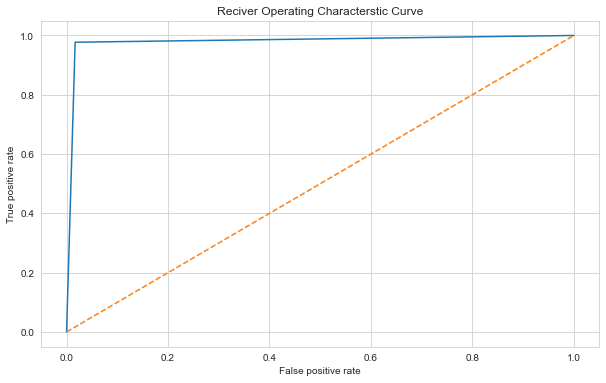

In [312]:
fpr,tpr,thr = roc_curve(ytest1,dt_s_p)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## knn SMOTE

In [313]:
knn_s = KNeighborsClassifier()
knn_s.fit(xtrain1,ytrain1)
knn_s_p = knn_s.predict(xtest1)

In [314]:
roc_auc = roc_auc_score(ytest1,knn_s_p)
accuracy_ = accuracy_score(ytest1,knn_s_p)
kappa_score_ = cohen_kappa_score(ytest1,knn_s_p)  
f1_ = f1_score(ytest1,knn_s_p)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest1,knn_s_p))

roc_auc: 0.9743073695028476
accuracy: 0.9659979598775926
kappa_score: 0.9258726813031808
f1 0.9521492942020895
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     23353
           1       0.91      1.00      0.95     11939

    accuracy                           0.97     35292
   macro avg       0.95      0.97      0.96     35292
weighted avg       0.97      0.97      0.97     35292



In [315]:
confusion = confusion_matrix(ytest1,knn_s_p)
confusion

array([[22153,  1200],
       [    0, 11939]], dtype=int64)

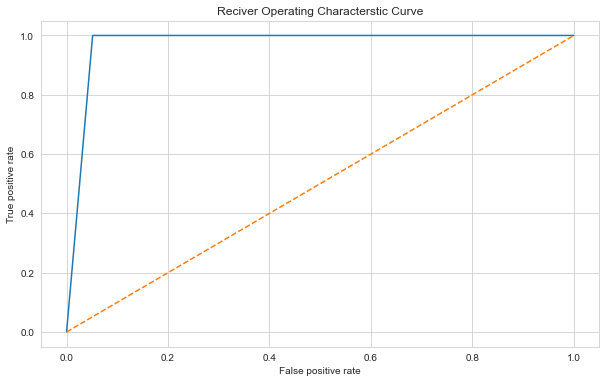

In [316]:
fpr,tpr,thr = roc_curve(ytest1,knn_s_p)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## AdaBoost Smote

In [318]:
from sklearn.ensemble import AdaBoostClassifier

In [319]:
ad_s = AdaBoostClassifier()
ad_s.fit(xtrain1,ytrain1)
aad_s_pred = ad_s.predict(xtest1)

In [320]:
roc_auc = roc_auc_score(ytest1,aad_s_pred)
accuracy_ = accuracy_score(ytest1,aad_s_pred)
kappa_score_ = cohen_kappa_score(ytest1,aad_s_pred)  
f1_ = f1_score(ytest1,aad_s_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest1,aad_s_pred))

roc_auc: 0.9306302383897288
accuracy: 0.9328459707582455
kappa_score: 0.8516723781516443
f1 0.9029801866710333
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     23353
           1       0.88      0.92      0.90     11939

    accuracy                           0.93     35292
   macro avg       0.92      0.93      0.93     35292
weighted avg       0.93      0.93      0.93     35292



In [321]:
confusion = confusion_matrix(ytest1,aad_s_pred)
confusion

array([[21893,  1460],
       [  910, 11029]], dtype=int64)

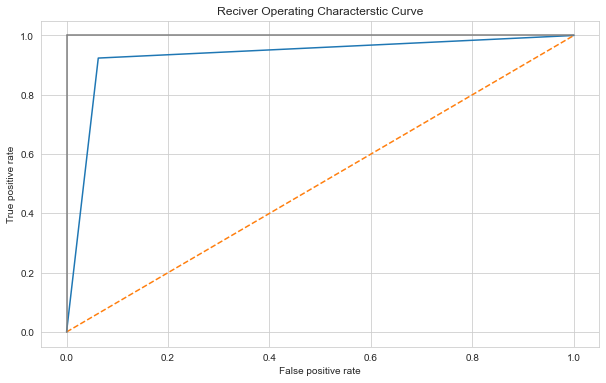

In [322]:
fpr,tpr,thr = roc_curve(ytest1,aad_s_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## XG Boost Smote

In [324]:
from xgboost import XGBClassifier

In [325]:
xg_s = XGBClassifier()
xg_s.fit(xtrain1,ytrain1)
xg_s_pred = xg_s.predict(xtest1)

In [326]:
roc_auc = roc_auc_score(ytest1,xg_s_pred)
accuracy_ = accuracy_score(ytest1,xg_s_pred)
kappa_score_ = cohen_kappa_score(ytest1,xg_s_pred)  
f1_ = f1_score(ytest1,xg_s_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest1,xg_s_pred))

roc_auc: 0.9928343424268128
accuracy: 0.9937946276776607
kappa_score: 0.9861329440814322
f1 0.9908195346887445
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     23353
           1       0.99      0.99      0.99     11939

    accuracy                           0.99     35292
   macro avg       0.99      0.99      0.99     35292
weighted avg       0.99      0.99      0.99     35292



In [327]:
confusion = confusion_matrix(ytest1,xg_s_pred)
confusion

array([[23255,    98],
       [  121, 11818]], dtype=int64)

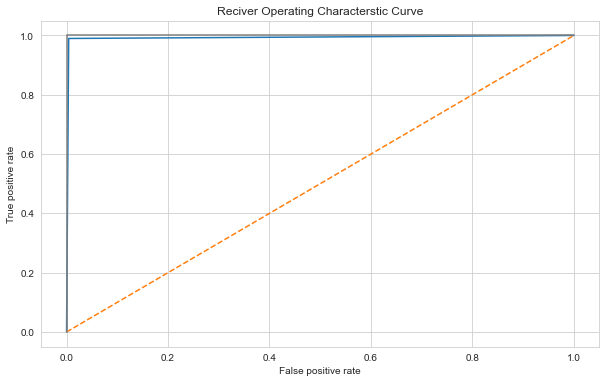

In [328]:
fpr,tpr,thr = roc_curve(ytest1,xg_s_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## LightGBM SMOTE

In [330]:
from lightgbm import LGBMClassifier

In [331]:
LM_s = LGBMClassifier()
LM_s.fit(xtrain1, ytrain1)
LM_s_pred = LM_s.predict(xtest1)

In [332]:
roc_auc = roc_auc_score(ytest1,LM_s_pred)
accuracy_ = accuracy_score(ytest1,LM_s_pred)
kappa_score_ = cohen_kappa_score(ytest1,LM_s_pred)  
f1_ = f1_score(ytest1,LM_s_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest1,LM_s_pred))

roc_auc: 0.9883430834643542
accuracy: 0.9886093165589935
kappa_score: 0.9746114345593571
f1 0.9832374280710532
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     23353
           1       0.98      0.99      0.98     11939

    accuracy                           0.99     35292
   macro avg       0.99      0.99      0.99     35292
weighted avg       0.99      0.99      0.99     35292



In [333]:
confusion = confusion_matrix(ytest1,LM_s_pred)
confusion

array([[23100,   253],
       [  149, 11790]], dtype=int64)

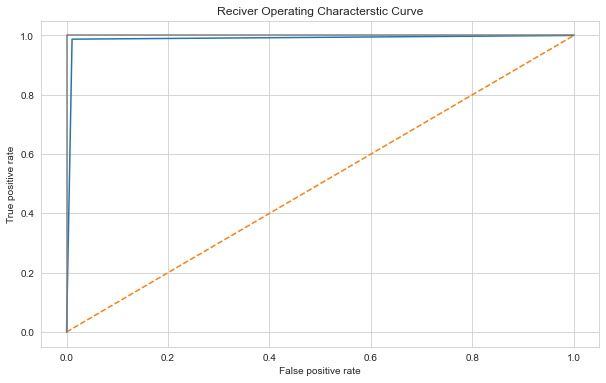

In [334]:
fpr,tpr,thr = roc_curve(ytest1,LM_s_pred)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Tuned Models with all the Features

### KNN_Tuning

In [442]:
knn_Tuned = KNeighborsClassifier()
tuned_params = [{'n_neighbors':[3,4,5],'p':[1,2,3]}]

In [443]:
knn_grid=GridSearchCV(estimator=knn_Tuned,param_grid=tuned_params,cv=2,n_jobs=-1)
knn_grid.fit(xtrain,ytrain)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5], 'p': [1, 2, 3]}])

In [444]:
knn_grid.best_params_

{'n_neighbors': 4, 'p': 1}

### KNN_Tuned Model

In [445]:
knn_tuned = KNeighborsClassifier(n_neighbors=4,p=1)
knn_tuned.fit(xtrain,ytrain)
knn_tuned_pred = knn_tuned.predict(xtest)

In [446]:
roc_auc = roc_auc_score(ytest,knn_tuned_pred)
accuracy_ = accuracy_score(ytest,knn_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest,knn_tuned_pred)  
f1_ = f1_score(ytest,knn_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,knn_tuned_pred))

roc_auc: 0.5187939929709144
accuracy: 0.9899196120964655
kappa_score: 0.06926369180859193
f1 0.07058823529411765
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.50      0.04      0.07       158

    accuracy                           0.99     15674
   macro avg       0.75      0.52      0.53     15674
weighted avg       0.99      0.99      0.99     15674



In [447]:
confusion_matrix(ytest,knn_tuned_pred)

array([[15510,     6],
       [  152,     6]], dtype=int64)

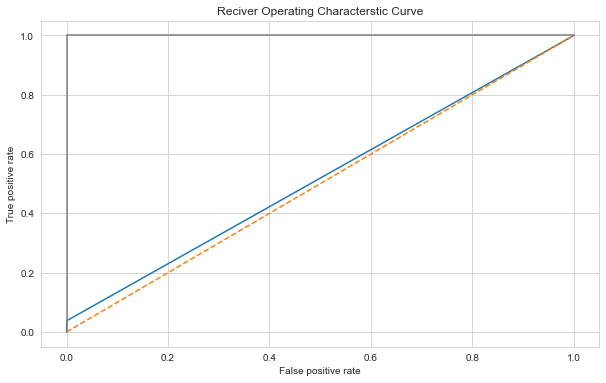

In [448]:
fpr,tpr,thr = roc_curve(ytest,knn_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Decision Tree Tuning

In [449]:
DT_Tuned = DecisionTreeClassifier()

In [450]:
tuned_param = [{'criterion':['gini','entropy'],'max_depth':[6,7,8],'min_samples_leaf':[2,3,6],'max_leaf_nodes':[2,3,4]}]
DT_grid=GridSearchCV(estimator=DT_Tuned,param_grid=tuned_param,cv=3,n_jobs=-1)
DT_grid.fit(xtrain,ytrain)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [6, 7, 8], 'max_leaf_nodes': [2, 3, 4],
                          'min_samples_leaf': [2, 3, 6]}])

In [451]:
DT_grid.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 2}

### Decision Tree Tuned Model

In [452]:
DT_tuned = DecisionTreeClassifier(criterion='gini',max_depth=6,max_leaf_nodes=2,min_samples_leaf=2)
DT_tuned.fit(xtrain,ytrain)
DT_tuned_pred = DT_tuned.predict(xtest)

In [453]:
roc_auc = roc_auc_score(ytest,DT_tuned_pred)
accuracy_ = accuracy_score(ytest,DT_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest,DT_tuned_pred)  
f1_ = f1_score(ytest,DT_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,DT_tuned_pred))

roc_auc: 0.5
accuracy: 0.9899196120964655
kappa_score: 0.0
f1 0.0
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.00      0.00      0.00       158

    accuracy                           0.99     15674
   macro avg       0.49      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [454]:
confusion_matrix(ytest,DT_tuned_pred)

array([[15516,     0],
       [  158,     0]], dtype=int64)

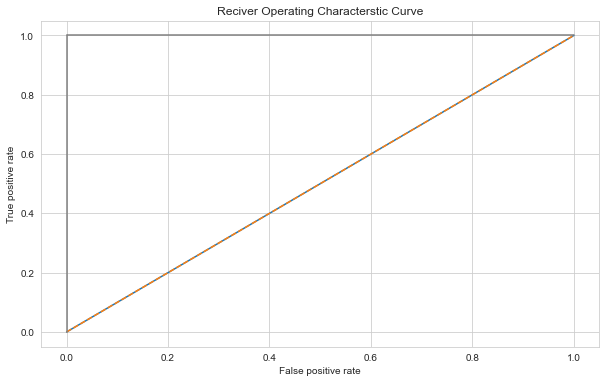

In [455]:
fpr,tpr,thr = roc_curve(ytest,DT_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Random Forest Tuning

In [456]:
RF_Tuned = RandomForestClassifier()

In [457]:
tuned_params = [{'criterion': ['entropy', 'gini'],'n_estimators': [10, 30, 50, 70, 90],'max_depth': [10, 15, 20],
                 'min_samples_leaf': [1, 5, 9],'max_leaf_nodes': [2, 5, 8,]}]
RF_grid=GridSearchCV(estimator=RF_Tuned,param_grid=tuned_params,cv=2,n_jobs=-1)
RF_grid.fit(xtrain,ytrain)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [10, 15, 20],
                          'max_leaf_nodes': [2, 5, 8],
                          'min_samples_leaf': [1, 5, 9],
                          'n_estimators': [10, 30, 50, 70, 90]}])

In [458]:
RF_grid.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_leaf_nodes': 8,
 'min_samples_leaf': 1,
 'n_estimators': 10}

### Random Forest Tuned Model

In [495]:
RF_tuned = RandomForestClassifier(criterion ='gini',max_depth=20,max_leaf_nodes=8,min_samples_leaf=1,n_estimators=10)
RF_tuned.fit(xtrain,ytrain)
RF_tuned_pred = RF_tuned.predict(xtest)

In [496]:
roc_auc = roc_auc_score(ytest,RF_tuned_pred)
accuracy_ = accuracy_score(ytest,RF_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest,RF_tuned_pred)  
f1_ = f1_score(ytest,RF_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,RF_tuned_pred))

roc_auc: 0.5031001073616128
accuracy: 0.9898558121730254
kappa_score: 0.012051220860029077
f1 0.012422360248447206
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.33      0.01      0.01       158

    accuracy                           0.99     15674
   macro avg       0.66      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [461]:
confusion_matrix(ytest,RF_tuned_pred)

array([[15513,     3],
       [  156,     2]], dtype=int64)

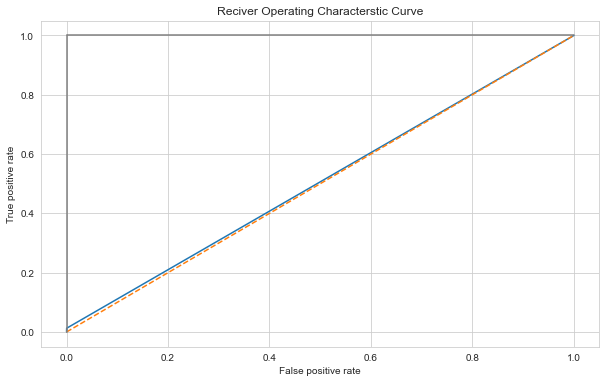

In [462]:
fpr,tpr,thr = roc_curve(ytest,RF_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Ada Boost Tuning

In [463]:
from sklearn.ensemble import AdaBoostClassifier

In [464]:
AD_Tuned = AdaBoostClassifier()

In [465]:
tuned_params =[{'n_estimators':[100,150,200],'learning_rate':[0.3,0.4,0.5]}]
AD_grid = GridSearchCV(estimator=AD_Tuned,param_grid=tuned_params,cv=2,n_jobs=-1)
AD_grid.fit(xtrain,ytrain)

GridSearchCV(cv=2, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.3, 0.4, 0.5],
                          'n_estimators': [100, 150, 200]}])

In [466]:
AD_grid.best_params_

{'learning_rate': 0.3, 'n_estimators': 100}

### AdaBoost Tuned Model

In [467]:
AD_tuned= AdaBoostClassifier(learning_rate=0.3, n_estimators=100)
AD_tuned.fit(xtrain,ytrain)
AD_tuned_pred = AD_tuned.predict(xtest)

In [468]:
roc_auc = roc_auc_score(ytest,AD_tuned_pred)
accuracy_ = accuracy_score(ytest,AD_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest,AD_tuned_pred)  
f1_ = f1_score(ytest,AD_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest,AD_tuned_pred))

roc_auc: 0.5031323321618191
accuracy: 0.9899196120964655
kappa_score: 0.01225107769279632
f1 0.012499999999999999
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15516
           1       0.50      0.01      0.01       158

    accuracy                           0.99     15674
   macro avg       0.74      0.50      0.50     15674
weighted avg       0.99      0.99      0.99     15674



In [469]:
confusion_matrix(ytest,AD_tuned_pred)

array([[15515,     1],
       [  157,     1]], dtype=int64)

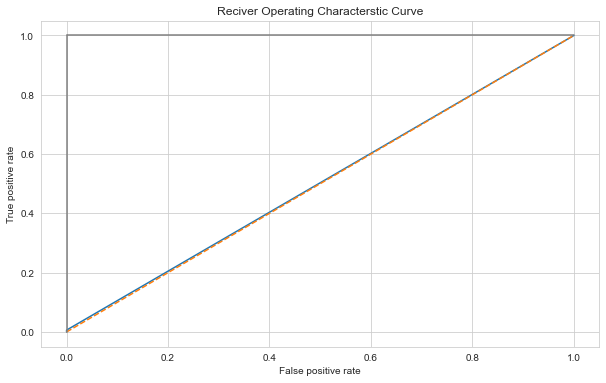

In [470]:
fpr,tpr,thr = roc_curve(ytest,AD_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Tuned Models with Significant Features

### KNN Tuning

In [471]:
knn_Sig_Tuned = KNeighborsClassifier()
tuned_params = [{'n_neighbors':[3,4,5],'p':[1,2,3]}]

In [472]:
knn_sig_grid=GridSearchCV(estimator=knn_Sig_Tuned,param_grid=tuned_params,cv=2,n_jobs=-1)
knn_sig_grid.fit(xtrain_2,ytrain_2)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5], 'p': [1, 2, 3]}])

In [473]:
knn_sig_grid.best_params_

{'n_neighbors': 4, 'p': 1}

### KNN Tuned Model

In [474]:
knn_sig_tuned = KNeighborsClassifier(n_neighbors=4 ,p=1 )
knn_sig_tuned.fit(xtrain_2,ytrain_2)
knn_sig_tuned_pred = knn_sig_tuned.predict(xtest_2)

In [475]:
roc_auc = roc_auc_score(ytest_2,knn_sig_tuned_pred)
accuracy_ = accuracy_score(ytest_2,knn_sig_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest_2,knn_sig_tuned_pred)  
f1_ = f1_score(ytest_2,knn_sig_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,knn_sig_tuned_pred))

roc_auc: 0.512288574457261
accuracy: 0.9895368125558249
kappa_score: 0.045047280735449946
f1 0.046511627906976744
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.31      0.03      0.05       159

    accuracy                           0.99     15674
   macro avg       0.65      0.51      0.52     15674
weighted avg       0.98      0.99      0.99     15674



In [476]:
confusion_matrix(ytest_2,knn_sig_tuned_pred)

array([[15506,     9],
       [  155,     4]], dtype=int64)

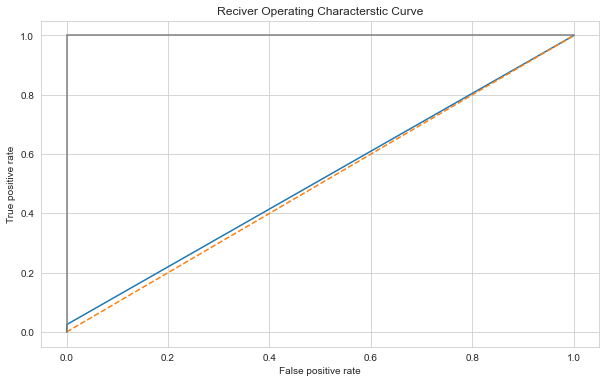

In [477]:
fpr,tpr,thr = roc_curve(ytest_2,knn_sig_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Decision Tree Tuning

In [478]:
DT_Sig_Tuned = DecisionTreeClassifier()

In [479]:
tuned_params = [{'criterion':['gini','entropy'],'max_depth':[6,7,8],'min_samples_leaf':[2,3,6],'max_leaf_nodes':[2,3,4]}]
DT_sig_grid=GridSearchCV(estimator=DT_Sig_Tuned,param_grid=tuned_params,cv=2,n_jobs=-1)
DT_sig_grid.fit(xtrain_2,ytrain_2)

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [6, 7, 8], 'max_leaf_nodes': [2, 3, 4],
                          'min_samples_leaf': [2, 3, 6]}])

In [480]:
DT_sig_grid.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 2}

### Decision Tree Tuned Model

In [481]:
DT_sig_tuned = DecisionTreeClassifier(criterion='gini',max_depth=6,max_leaf_nodes=2,min_samples_leaf=2)
DT_sig_tuned.fit(xtrain_2,ytrain_2)
DT_sig_tuned_pred = DT_sig_tuned.predict(xtest_2)

In [482]:
roc_auc = roc_auc_score(ytest_2,DT_sig_tuned_pred)
accuracy_ = accuracy_score(ytest_2,DT_sig_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest_2,DT_sig_tuned_pred)  
f1_ = f1_score(ytest_2,DT_sig_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,DT_sig_tuned_pred))

roc_auc: 0.5
accuracy: 0.9898558121730254
kappa_score: 0.0
f1 0.0
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.00      0.00      0.00       159

    accuracy                           0.99     15674
   macro avg       0.49      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [483]:
confusion_matrix(ytest_2,DT_sig_tuned_pred)

array([[15515,     0],
       [  159,     0]], dtype=int64)

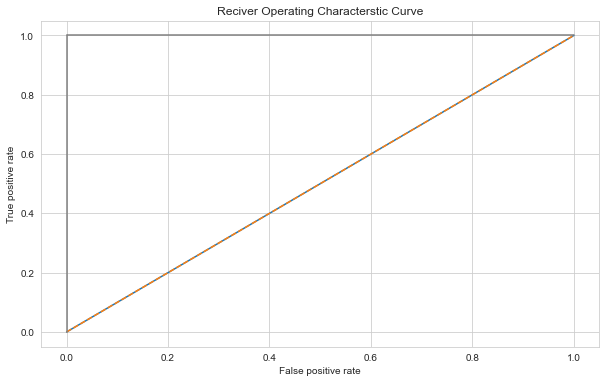

In [484]:
fpr,tpr,thr = roc_curve(ytest_2,DT_sig_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Random Forest Tuning

In [485]:
RF_Sig_Tuned = RandomForestClassifier()

In [486]:
tuned_params = [{'criterion': ['entropy', 'gini'],'n_estimators': [10, 30, 50, 70, 90],'max_depth': [10, 15, 20],
                 'min_samples_leaf': [1, 5, 9],'max_leaf_nodes': [2, 5, 8,]}]
RF_sig_grid=GridSearchCV(estimator=RF_Sig_Tuned,param_grid=tuned_params,cv=2,n_jobs=-1)
RF_sig_grid.fit(xtrain_2,ytrain_2)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [10, 15, 20],
                          'max_leaf_nodes': [2, 5, 8],
                          'min_samples_leaf': [1, 5, 9],
                          'n_estimators': [10, 30, 50, 70, 90]}])

In [487]:
RF_sig_grid.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_leaf_nodes': 8,
 'min_samples_leaf': 1,
 'n_estimators': 10}

### Random Forest Tuned Model

In [489]:
RF_sig_tuned = RandomForestClassifier(criterion='gini', max_depth=20, max_leaf_nodes=8,min_samples_leaf=1,n_estimators=10)
RF_sig_tuned.fit(xtrain_2,ytrain_2)
RF_sig_tuned_pred = RF_sig_tuned.predict(xtest_2)

In [490]:
roc_auc = roc_auc_score(ytest_2,RF_sig_tuned_pred)
accuracy_ = accuracy_score(ytest_2,RF_sig_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest_2,RF_sig_tuned_pred)  
f1_ = f1_score(ytest_2,RF_sig_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,RF_sig_tuned_pred))

roc_auc: 0.5030802003336191
accuracy: 0.9897920122495854
kappa_score: 0.011974467287097945
f1 0.01234567901234568
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.33      0.01      0.01       159

    accuracy                           0.99     15674
   macro avg       0.66      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [491]:
confusion_matrix(ytest_2,RF_sig_tuned_pred)

array([[15513,     2],
       [  158,     1]], dtype=int64)

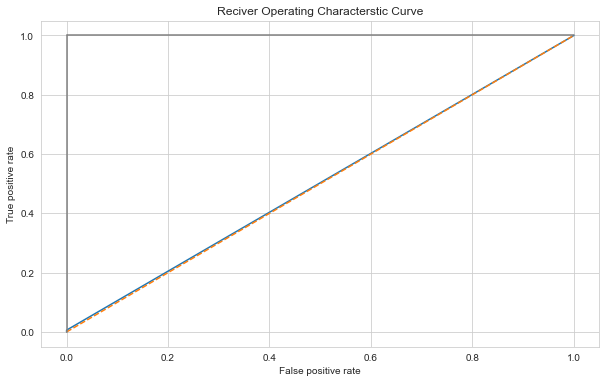

In [492]:
fpr,tpr,thr = roc_curve(ytest_2,RF_sig_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Ada Boost Tuning

In [493]:
AD_Sig_Tuned = AdaBoostClassifier()

In [494]:
tuned_params =[{'n_estimators':[100,150,200],'learning_rate':[0.3,0.4,0.5]}]
AD_sig_grid = GridSearchCV(estimator=AD_Sig_Tuned,param_grid=tuned_params,cv=2,n_jobs=-1)
AD_sig_grid.fit(xtrain_2,ytrain_2)

GridSearchCV(cv=2, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.3, 0.4, 0.5],
                          'n_estimators': [100, 150, 200]}])

In [497]:
AD_sig_grid.best_params_

{'learning_rate': 0.4, 'n_estimators': 150}

### Ada Boost Tuned Model

In [498]:
AD_sig_tuned= AdaBoostClassifier(learning_rate=0.4, n_estimators=150)
AD_sig_tuned.fit(xtrain_2,ytrain_2)
AD_sig_tuned_pred = AD_sig_tuned.predict(xtest_2)

In [499]:
roc_auc = roc_auc_score(ytest_2,AD_sig_tuned_pred)
accuracy_ = accuracy_score(ytest_2,AD_sig_tuned_pred)
kappa_score_ = cohen_kappa_score(ytest_2,AD_sig_tuned_pred)  
f1_ = f1_score(ytest_2,AD_sig_tuned_pred)
print('roc_auc:',roc_auc)
print('accuracy:',accuracy_)
print('kappa_score:', kappa_score_)
print('f1',f1_)
print('Classification Report:','\n',classification_report(ytest_2,AD_sig_tuned_pred))

roc_auc: 0.5
accuracy: 0.9898558121730254
kappa_score: 0.0
f1 0.0
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15515
           1       0.00      0.00      0.00       159

    accuracy                           0.99     15674
   macro avg       0.49      0.50      0.50     15674
weighted avg       0.98      0.99      0.98     15674



In [500]:
confusion_matrix(ytest_2,AD_sig_tuned_pred)

array([[15515,     0],
       [  159,     0]], dtype=int64)

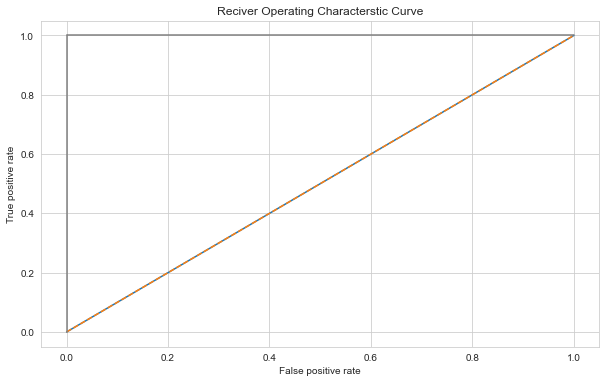

In [501]:
fpr,tpr,thr = roc_curve(ytest_2,AD_sig_tuned_pred)
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(fpr,tpr)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()